In [0]:
import time
start_time = time.time()

The goal of this project is to predict a song's genre based on its musical attributes.

In [0]:
!pip install scikit-plot

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import timeit
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.datasets import make_classification
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_predict
from sklearn import preprocessing
import matplotlib.pyplot as plt

import scikitplot as skplt

import seaborn as sns
sns.set_palette('pastel')
sns.set(style="whitegrid")

In [0]:
df = pd.read_csv('SpotifyFeatures.csv') # https://www.kaggle.com/zaheenhamidani/ultimate-spotify-tracks-db

# Exploration / Data Cleaning

In [0]:
df.head()

genre        artist_name  ... time_signature valence
0  Movie     Henri Salvador  ...            4/4   0.814
1  Movie  Martin & les fées  ...            4/4   0.816
2  Movie    Joseph Williams  ...            5/4   0.368
3  Movie     Henri Salvador  ...            4/4   0.227
4  Movie       Fabien Nataf  ...            4/4   0.390

[5 rows x 18 columns]

In [0]:
# get num rows

df.shape

(232725, 18)

In [0]:
# get datatypes

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232725 entries, 0 to 232724
Data columns (total 18 columns):
genre               232725 non-null object
artist_name         232725 non-null object
track_name          232725 non-null object
track_id            232725 non-null object
popularity          232725 non-null int64
acousticness        232725 non-null float64
danceability        232725 non-null float64
duration_ms         232725 non-null int64
energy              232725 non-null float64
instrumentalness    232725 non-null float64
key                 232725 non-null object
liveness            232725 non-null float64
loudness            232725 non-null float64
mode                232725 non-null object
speechiness         232725 non-null float64
tempo               232725 non-null float64
time_signature      232725 non-null object
valence             232725 non-null float64
dtypes: float64(9), int64(2), object(7)
memory usage: 32.0+ MB


In [0]:
df.describe()

popularity   acousticness  ...          tempo        valence
count  232725.000000  232725.000000  ...  232725.000000  232725.000000
mean       41.127502       0.368560  ...     117.666585       0.454917
std        18.189948       0.354768  ...      30.898907       0.260065
min         0.000000       0.000000  ...      30.379000       0.000000
25%        29.000000       0.037600  ...      92.959000       0.237000
50%        43.000000       0.232000  ...     115.778000       0.444000
75%        55.000000       0.722000  ...     139.054000       0.660000
max       100.000000       0.996000  ...     242.903000       1.000000

[8 rows x 11 columns]

In [0]:
df.genre.value_counts()

Comedy              9681
Soundtrack          9646
Indie               9543
Jazz                9441
Pop                 9386
Electronic          9377
Children’s Music    9353
Folk                9299
Hip-Hop             9295
Rock                9272
Alternative         9263
Classical           9256
Rap                 9232
World               9096
Soul                9089
Blues               9023
R&B                 8992
Anime               8936
Reggaeton           8927
Ska                 8874
Reggae              8771
Dance               8701
Country             8664
Opera               8280
Movie               7806
Children's Music    5403
A Capella            119
Name: genre, dtype: int64

## Exploring Features

Let's look at the distributions of features.

I consider song attributes "concrete" if they are a factual measurement (eg. duration) as opposed to arbitrary estimations (eg. danceability).

The following features are original measurements by Spotify, aka not concrete. 

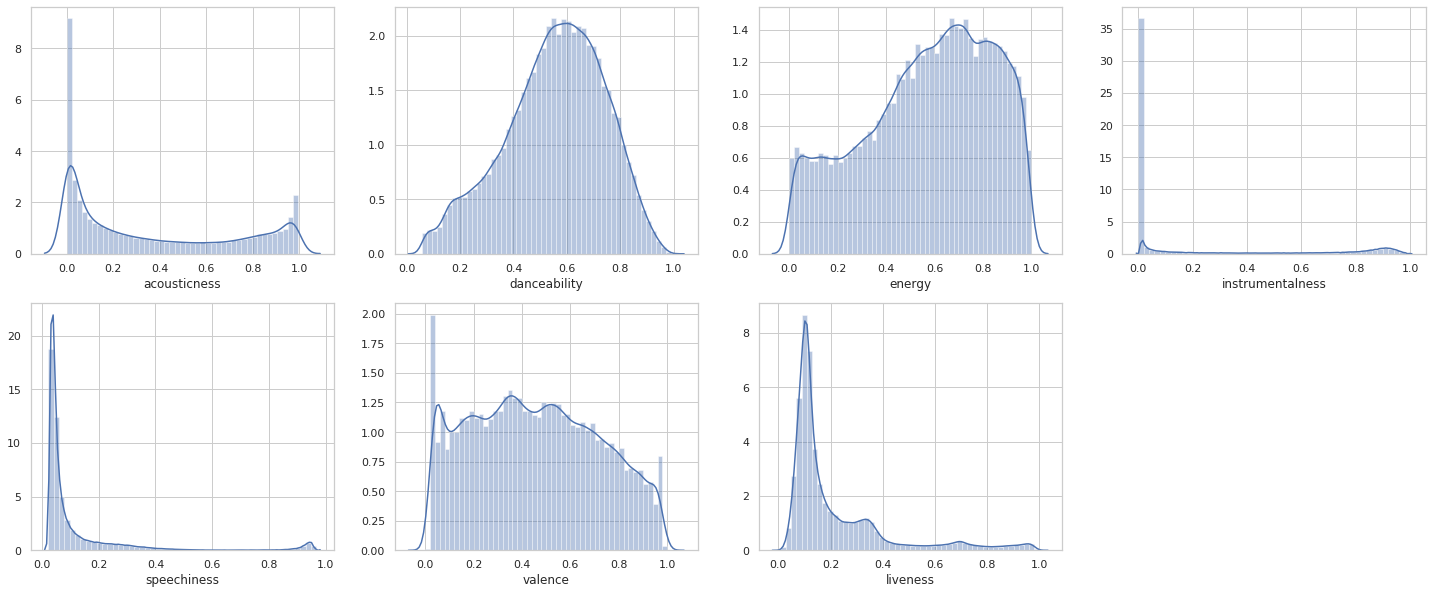

In [0]:
plt.figure(figsize=(25,10))

range = df[df.duration_ms <= 1000000]
plt.subplot(241)
sns.distplot(range.acousticness)

plt.subplot(242)
sns.distplot(df.danceability)

plt.subplot(243)
sns.distplot(df.energy)

plt.subplot(244)
sns.distplot(df.instrumentalness)

plt.subplot(245)
sns.distplot(df.speechiness)

plt.subplot(246)
sns.distplot(df.valence)

plt.subplot(247)
sns.distplot(df.liveness)

Next, let's take a look at the distributions of the concrete, continuous features.

Text(0.5, 1.0, 'histogram of track tempo (BPM)')

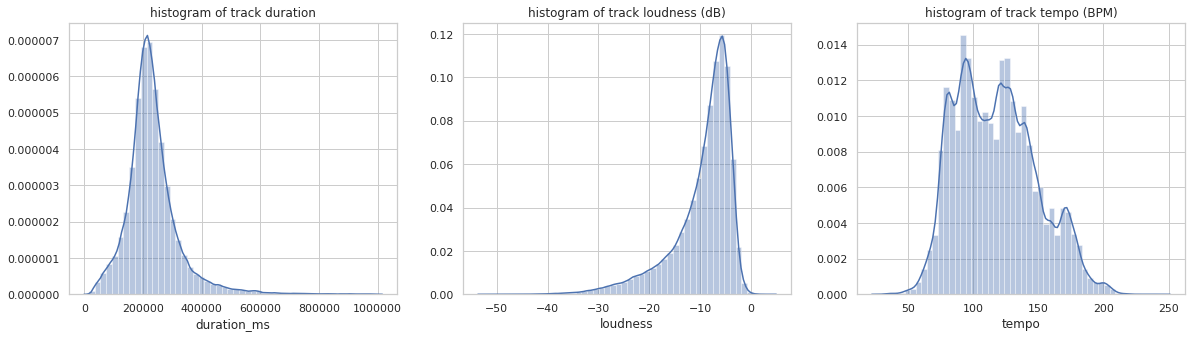

In [0]:
plt.figure(figsize=(20,5))

range = df[df.duration_ms <= 1000000]
plt.subplot(131)
sns.distplot(range.duration_ms)
plt.title("histogram of {}".format("track duration"))

plt.subplot(132)
sns.distplot(df.loudness)
plt.title("histogram of {}".format("track loudness (dB)"))

plt.subplot(133)
sns.distplot(df.tempo)
plt.title("histogram of {}".format("track tempo (BPM)"))

#### Duration
It seems track duration has a distribution centered around 200,000 milliseconds (3.33 minutes) which seems about right for the average song. The longer tracks are likely podcasts or other more lengthy media forms.

#### Loudness
Track loudness seems to average around -6dB and top out around 0dB, which makes sense since there is a general loudness standard for digital music streaming.

#### Tempo
While tempo is fairle evenly distributed, there are noticeable peaks at certain BPMs. This is likely due to certain genres having a common tempo or tempo range.

Now let's take a look at the distributions of the categorical features of the songs (which are all concrete).

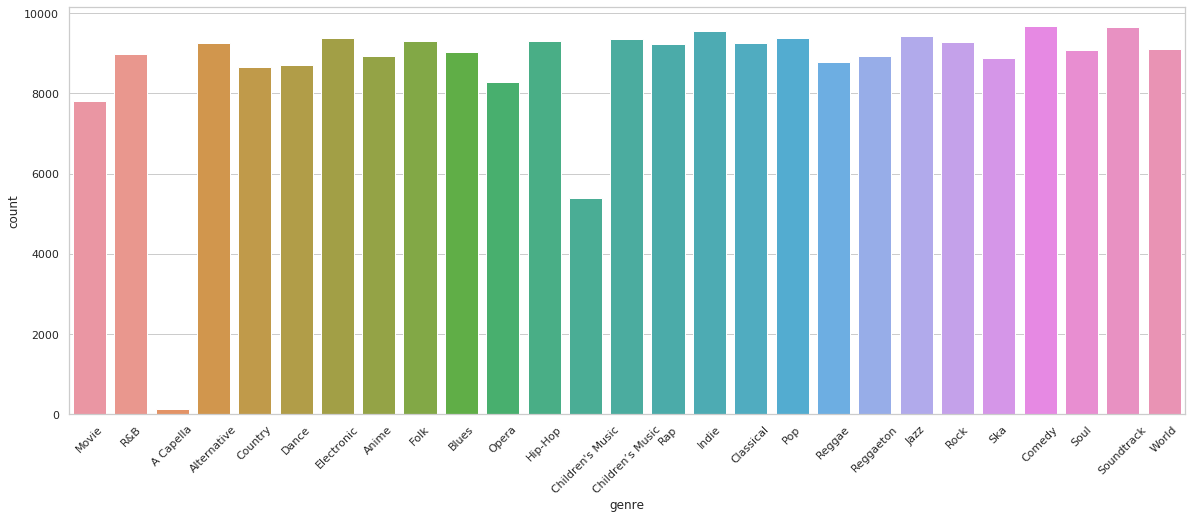

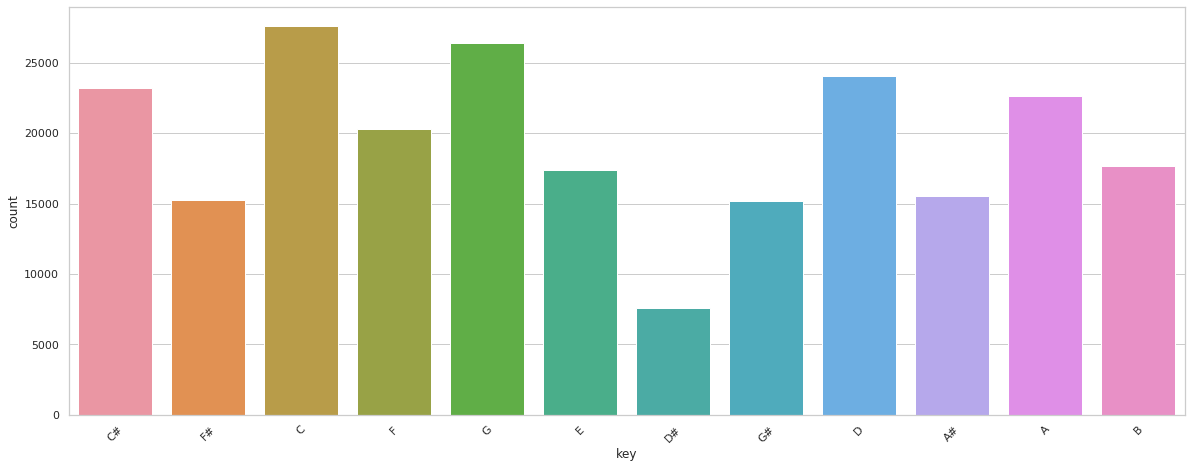

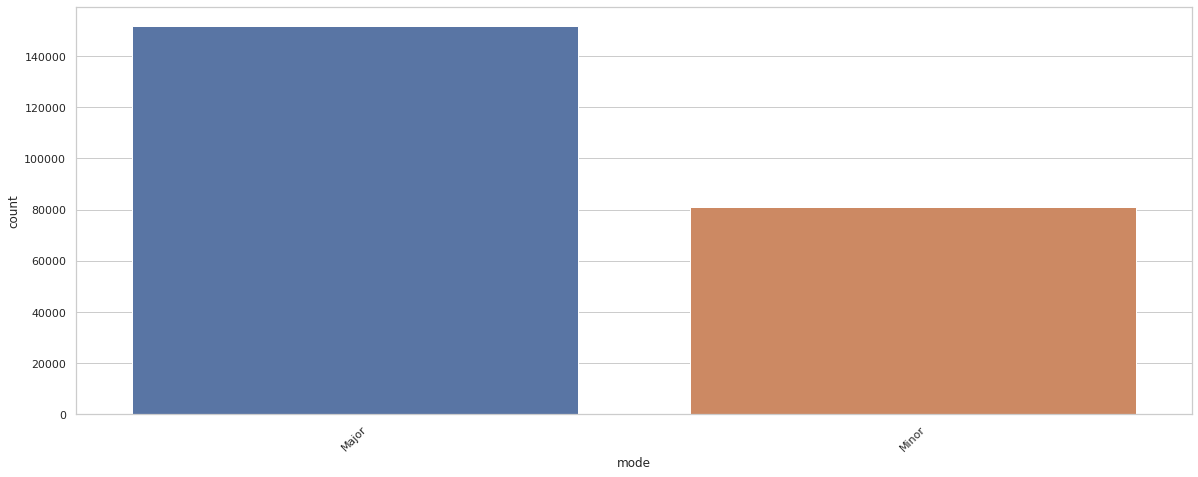

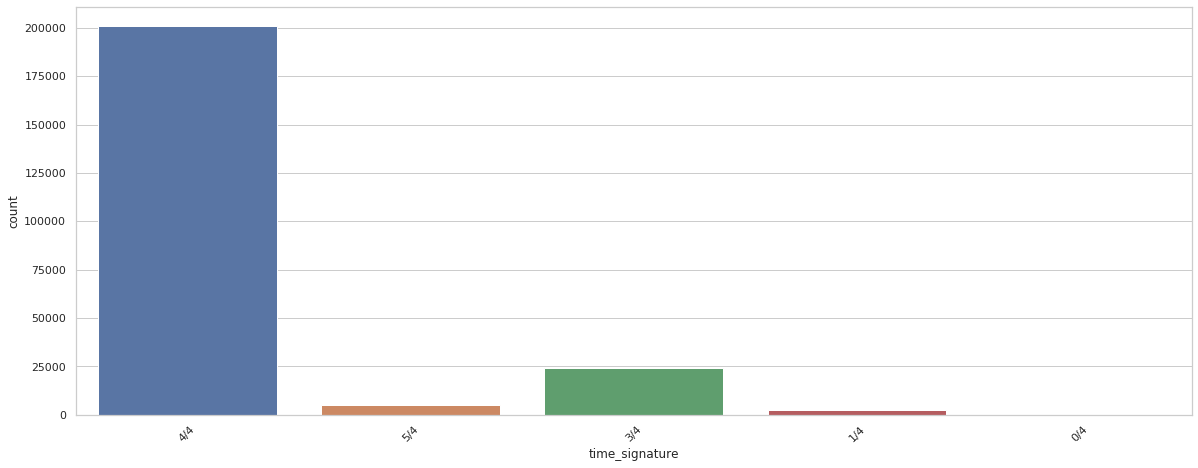

In [0]:
cats = ['genre', 'key', 'mode', 'time_signature']

for cat in cats:
    plt.figure(figsize=(20,7.5))
    plt.xticks(rotation=45)
    sns.countplot(x=cat, data=df)

#### Genre
Looking at the genre categories, we can see that each genre is fairly evenly represented aside from A Capella and Children's Music.

This is not a coincidence, since the curator of this dataset aimed to have an equivalent amount of tracks from each genre.

A Capella music likely has low representation since it is a generally uncommon genre. An A Capella track is usually just a version of a song with the instrumentation removed, so I may not even want to consider it a genre in my experiment.

Taking a closer look, it seems Children's Music is listed twice. Let's find out why.

In [0]:
df.genre.value_counts()

Comedy              9681
Soundtrack          9646
Indie               9543
Jazz                9441
Pop                 9386
Electronic          9377
Children’s Music    9353
Folk                9299
Hip-Hop             9295
Rock                9272
Alternative         9263
Classical           9256
Rap                 9232
World               9096
Soul                9089
Blues               9023
R&B                 8992
Anime               8936
Reggaeton           8927
Ska                 8874
Reggae              8771
Dance               8701
Country             8664
Opera               8280
Movie               7806
Children's Music    5403
A Capella            119
Name: genre, dtype: int64

So, Children's Music is listed twice using two different types of apostrophes ( ' and ’ ).

I'll get rid of the one with ' since it's the outlier in terms of representation.

In [0]:
dropIndex = df[df.genre == "Children's Music"].index
df.drop(dropIndex, inplace=True)

In [0]:
df.genre.value_counts()

Comedy              9681
Soundtrack          9646
Indie               9543
Jazz                9441
Pop                 9386
Electronic          9377
Children’s Music    9353
Folk                9299
Hip-Hop             9295
Rock                9272
Alternative         9263
Classical           9256
Rap                 9232
World               9096
Soul                9089
Blues               9023
R&B                 8992
Anime               8936
Reggaeton           8927
Ska                 8874
Reggae              8771
Dance               8701
Country             8664
Opera               8280
Movie               7806
A Capella            119
Name: genre, dtype: int64

#### Key
My first observation here is that the creator of this dataset changed the key categories from their pitch class notation (integer from 0-11) to the corresponding key letters.

Keys C and G seem to be the most popular keys by a slight margin, while D# is clearly the least common.

These findings seem to be aligned with those of this Gizmodo article https://io9.gizmodo.com/a-chart-of-the-most-commonly-used-keys-shows-our-actual-1703086174https://io9.gizmodo.com/a-chart-of-the-most-commonly-used-keys-shows-our-actual-1703086174

and this accompanying chart: 

![Common keys](http://www.jmlmusic.no/uploads/3/7/3/7/37379277/published/keys-spotify.png?1504299412)

Therefore, I will not attribute these findings to any error.

#### Mode
While I couldn't find any official documentation on the commonality of major vs minor scales in music, my findings while exploring other datasets as well as fetching my own songs through Spotify's API align with these, showing that major scales are likely more common.

#### Time Signature
Again, the dataset creator has modified the values in this category. Spotify provides the time signature of songs as an integer value representing the amount of beats per measure.
A measure is generally divided into fourths, so for example, a 4 would mean 4/4 time, a 7 would be 7/4 time, etc. However, it seems the creator has converted from the integer value to a string representing the time signature. 4/4 is by far the most common time signature in music, so no problems there, but a 1/4 is quite obscure and 0/4 would mean there are no beats per measure, so this is definitely worth investigating.

Let's check out the 1/4 tracks first.

In [0]:
df[df.time_signature == '1/4']

genre         artist_name  ... time_signature valence
29      Movie              Chorus  ...            1/4   0.756
50      Movie        Claire Guyot  ...            1/4   0.371
55      Movie      Justin Hurwitz  ...            1/4   0.592
62      Movie      Henri Salvador  ...            1/4   0.336
74      Movie  Jean Claude Corbel  ...            1/4   0.493
...       ...                 ...  ...            ...     ...
232375   Soul                SOHN  ...            1/4   0.235
232380   Soul            Fantasia  ...            1/4   0.433
232445   Soul                IDER  ...            1/4   0.242
232610   Soul    Sofi de la Torre  ...            1/4   0.165
232667   Soul             Floetry  ...            1/4   0.144

[2542 rows x 18 columns]

There are 2510 tracks labelled with a 1/4 time signature. According to this article https://en.wikipedia.org/wiki/List_of_musical_works_in_unusual_time_signatures a 1/4 time signature is extremely rare. In the article, a few examples are given of songs that have 1/4 time, but even then it is only used in certain parts of the song. My point is that it is unlikely that the majority of these songs are actually in 1/4 time. In fact, I already see a song in the output that I know, Red Lines by SOHN, that is not in 1/4 time.

It would obviously be too tedious to listen to every song in this category and classify it correctly, so I believe it will be best to rebove them all, considering ~2500 rows is not too significant in this dataset.

In [0]:
dropIndex = df[df.time_signature == '1/4'].index
df.drop(dropIndex, inplace=True)

Now let's pull some 0/4 songs and see what's going on.

In [0]:
df[df.time_signature == '0/4']

genre          artist_name  ... time_signature valence
14520    Dance  The Black Eyed Peas  ...            0/4  0.4240
59106    Opera      Tomaso Albinoni  ...            0/4  0.0377
80544    Opera       Giuseppe Verdi  ...            0/4  0.0349
82665    Opera  Giuseppe Di Stefano  ...            0/4  0.2470
111059     Pop  The Black Eyed Peas  ...            0/4  0.4240
115895     Rap  The Black Eyed Peas  ...            0/4  0.4240
167567  Comedy            Ron White  ...            0/4  0.0672
208898   World           Aphex Twin  ...            0/4  0.0776

[8 rows x 18 columns]

It seems there's only 8 tracks labeled '0/4'. Could this mean they were just falsely categorized? Let's listen to one.

In [0]:
from music21 import midi

def playMidi(filename):
    mf = midi.MidiFile()
    mf.open(filename)
    mf.read()
    mf.close()
    s = midi.translate.midiFileToStream(mf)
    s.show('midi')

In [0]:
playMidi('Nanou2.mp3.mid')

In [0]:
from IPython.display import HTML

HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/US-N1u5km3c?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')

This track is quite ambient, consisting of only a piano. There is no discernable beat, which is likely why Spotify classified it as 0/4.

However, after listening to another track here, 'Imma Be' by the Black Eyed Peas, it's clear to me that although it's an unconventional beat, it's actually in 4/4 time.

In [0]:
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/kdAj-dBNCi4?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')

So, it seems Spotify does make some mistakes with its time signature identification, but fortunately there's only 8 entries for 0/4 time, so let's remove them.

In [0]:
dropIndex = df[df.time_signature == '0/4'].index
df.drop(dropIndex, inplace=True)

Now that that's taken care of, there's another realization I made here.

It seems some tracks, such as 'Imma Be', have multiple genres and therefore multiple entries in the dataset. Let's see how many of these duplicates we're dealing with.

## Duplicates

In [0]:
dups_total = df[df.duplicated(subset = 'track_id', keep=False)]
dups_unique = df[df.duplicated(subset = 'track_id', keep='first')]

print(len(dups_total), 'total duplicates')
print(len(dups_unique), 'unique duplicates')

90618 total duplicates
55685 unique duplicates


In [0]:
dups = df.groupby(['artist_name', 'track_name'], as_index=True).size()

print('There are {} duplicate entries out of {} total, or roughly {}%'.format(
    dups[dups > 1].count(), len(df.index), round(dups[dups > 1].count()/len(df.index), 2)*100))

There are 35061 duplicate entries out of 224772 total, or roughly 16.0%


That's a decently large number, but we can't have tracks labeled under multiple genres, and we also can't just choose one genre for tracks with multiple listings. So, it's probably best to remove all duplicate tracks.

In [0]:
# REMOVE DUPLICATES

# change keep to 'first' or 'last' to keep one entry for each duplicated song
df.drop_duplicates(subset='track_id', keep=False, inplace=True)

In [0]:
dups_total = df[df.duplicated(subset = 'track_id', keep=False)]
dups_unique = df[df.duplicated(subset = 'track_id', keep='first')]

dups = df.groupby(['artist_name', 'track_name'], as_index=True).size()

print('There are {} duplicate entries out of {} total, or roughly {}%'.format(
    len(dups_total), len(df.index), round(len(dups_total)/len(df.index), 2)*100))

There are 0 duplicate entries out of 134154 total, or roughly 0.0%


## Speechiness

Before moving on, there was one more entry labeled 0/4 that stood out to me. A Comedy track called	"Good to Be in Austin/Airport Security/Broke Tooth" by Ron White.

After listening to this track, I realised that it's not an actual song, but instead a recording of a stand-up comedy set. This got me wondering if all the tracks labeled "Comedy" are stand-up sets, or maybe just this one. Let's see.

In [0]:
df[df.genre == 'Comedy'].head()

genre      artist_name  ... time_signature valence
167303  Comedy       Bo Burnham  ...            4/4   0.357
167304  Comedy   Demetri Martin  ...            3/4   0.312
167305  Comedy  Sarah Silverman  ...            4/4   0.328
167306  Comedy       Bo Burnham  ...            4/4   0.356
167307  Comedy   Mike Birbiglia  ...            5/4   0.560

[5 rows x 18 columns]

So, it seems this is the worst case scenario. Some of these listings, such as "People Watching" by Demitri Martin are stand-up comedy sets, while others, like "Sad" by Bo Burnham are actual comedy songs.

Luckily, there seems to be a way to tell which is which. The stand-up comedy sets seem to have an unusually high 'speechiness' value, which makes sense since they are entirely composed of speech.

In [0]:
print('All of the stand-up tracks that I\'ve seen so far have had a speechiness value > 0.9, while the average of all tracks is only {}'.format(df.speechiness.mean()))
print('The average speechiness of \'Comedy\' tracks is {}, meaning the majority of them are spoken word, not songs.'.format(df[df.genre == 'Comedy'].speechiness.mean()))

All of the stand-up tracks that I've seen so far have had a speechiness value > 0.9, while the average of all tracks is only 0.13296326311552262
The average speechiness of 'Comedy' tracks is 0.852135680648342, meaning the majority of them are spoken word, not songs.


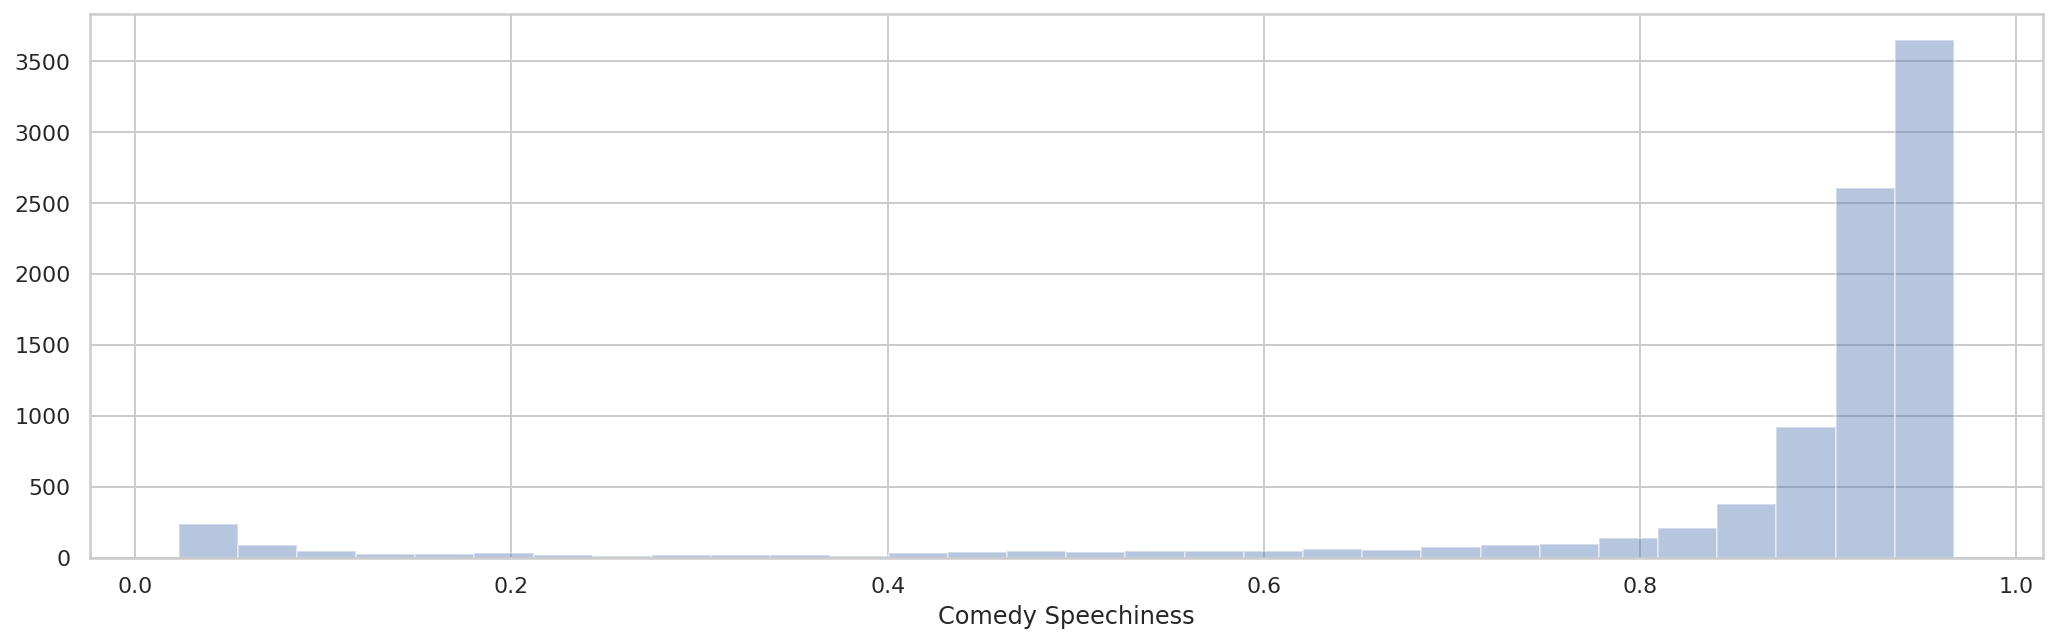

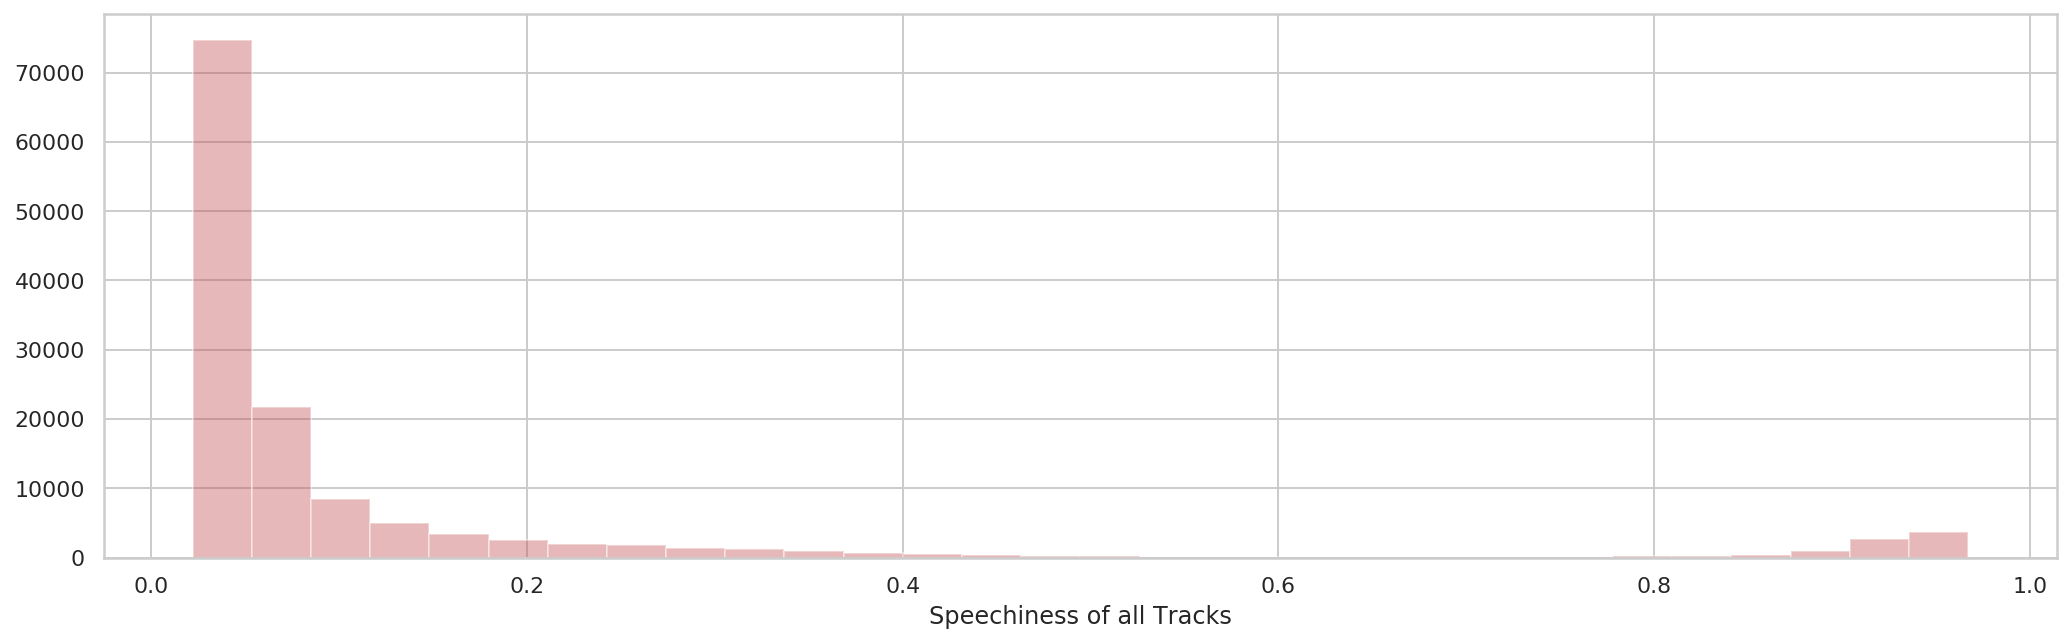

In [0]:
plt.figure(figsize=(17.5,5))

sns.distplot(df[df.genre == 'Comedy'].speechiness, kde=False, bins=30, color='b', axlabel='Comedy Speechiness')
plt.show()

plt.figure(figsize=(17.5,5))
sns.distplot(df.speechiness, kde=False, bins=30, color='r', axlabel='Speechiness of all Tracks')
plt.show()

We can see in the distribution of comedy speechiness that the majority of comedy tracks are spoken word. We can also see that there is a significant amount of high speechiness outliers in the overall distribution. That can't just be caused by the comedy tracks. 

Let's investigate speechiness in all genres.

Through further investigation, I've realized there are other tracks that consist of entirely spoken words besides stand-up comedy, namely, movie monologues and podcasts.

Again, I only want to include music in this experiment, so I would like to remove every track above a certain speechiness threshold. The only problem is determining this threshold...

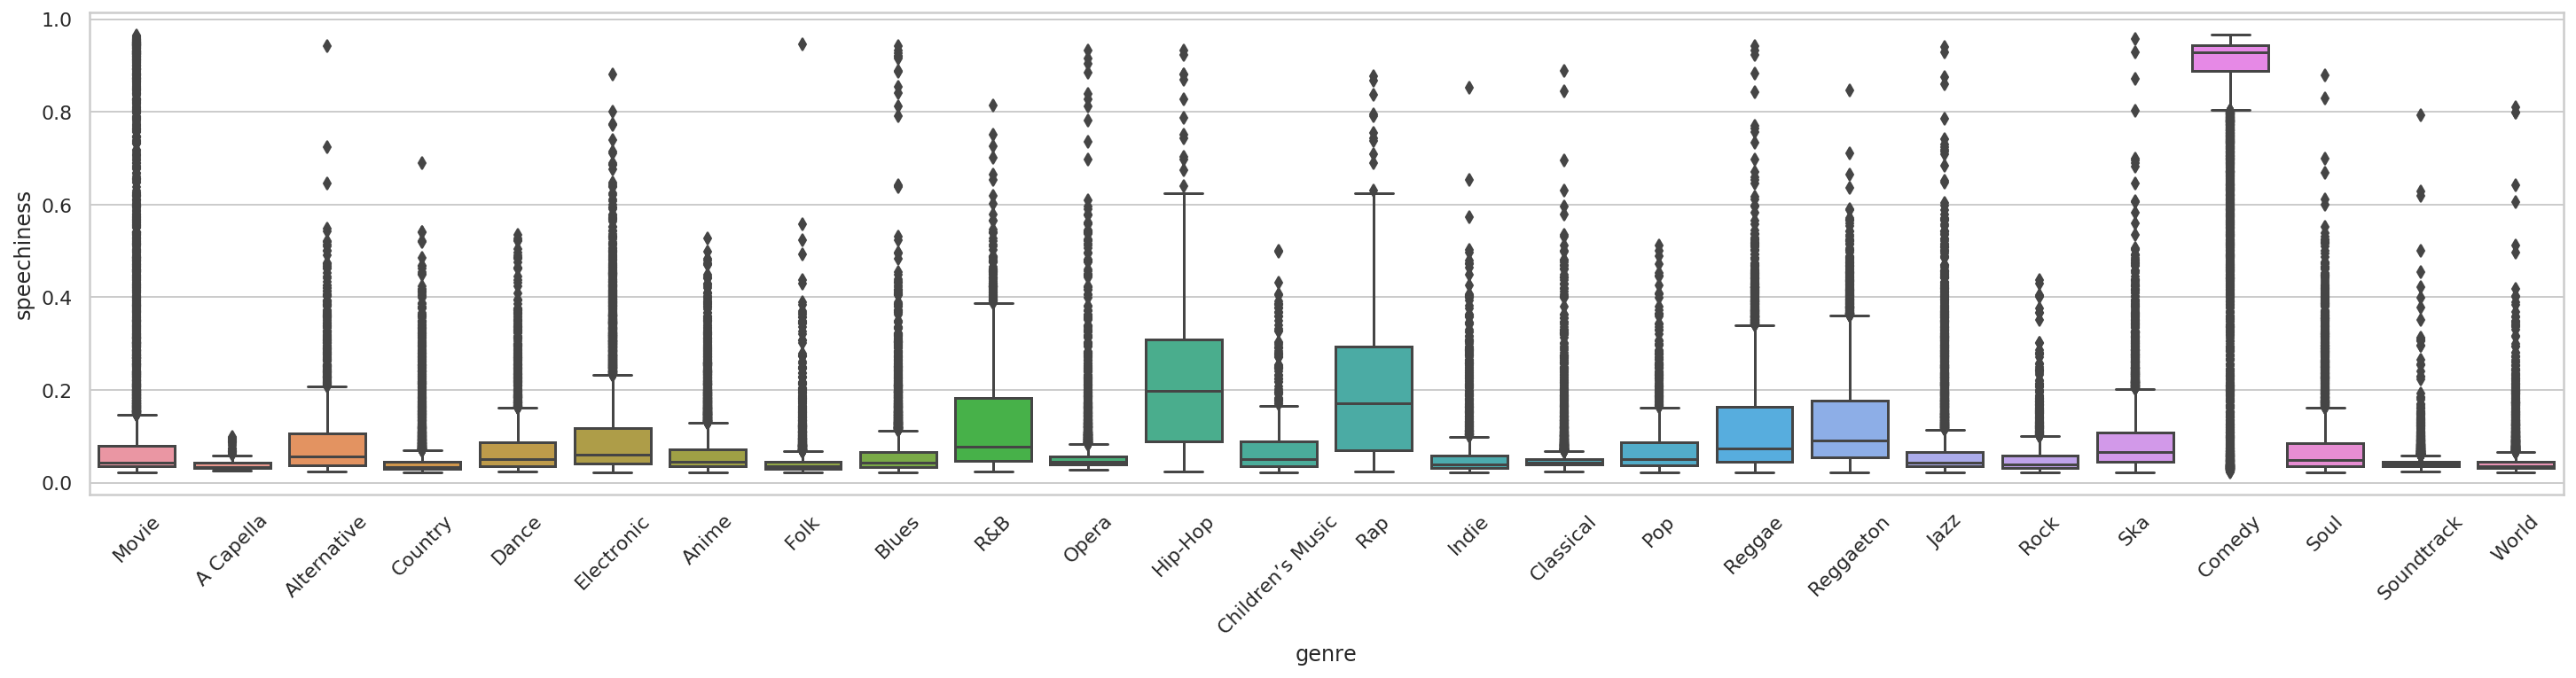

In [0]:
plt.figure(figsize=(25,5))
plt.xticks(rotation=45)
sns.boxplot(x='genre', y='speechiness', data=df)

So it seems there are high speechiness (spoken-word tracks) in most genres. Since I only want to analyze actual songs, and not things such as movie monologues, I'll have to determine a cutoff to remove tracks with a high speechiness score.

Looking at the boxplots of the speechiness distributions, it seems that aside from Comedy, the maximum, non-outlier speechiness scores are no higher than ~0.6, with Hip-Hop & Rap. That seems like a good cutoff for removing songs that are mostly spoken word and non-musical, considering rap and hip-hop are some of the most speech-heavy genres to begin with.

In [0]:
print('Removing {} tracks of {}.'.format(len(df[df.speechiness >= 0.6]), len(df.index), ))

Removing 8774 tracks of 134154.


In [0]:
# REMOVE SPEECHINESS OUTLIERS

dropIndex = df[df.speechiness >= 0.6].index
df.drop(dropIndex, inplace=True)

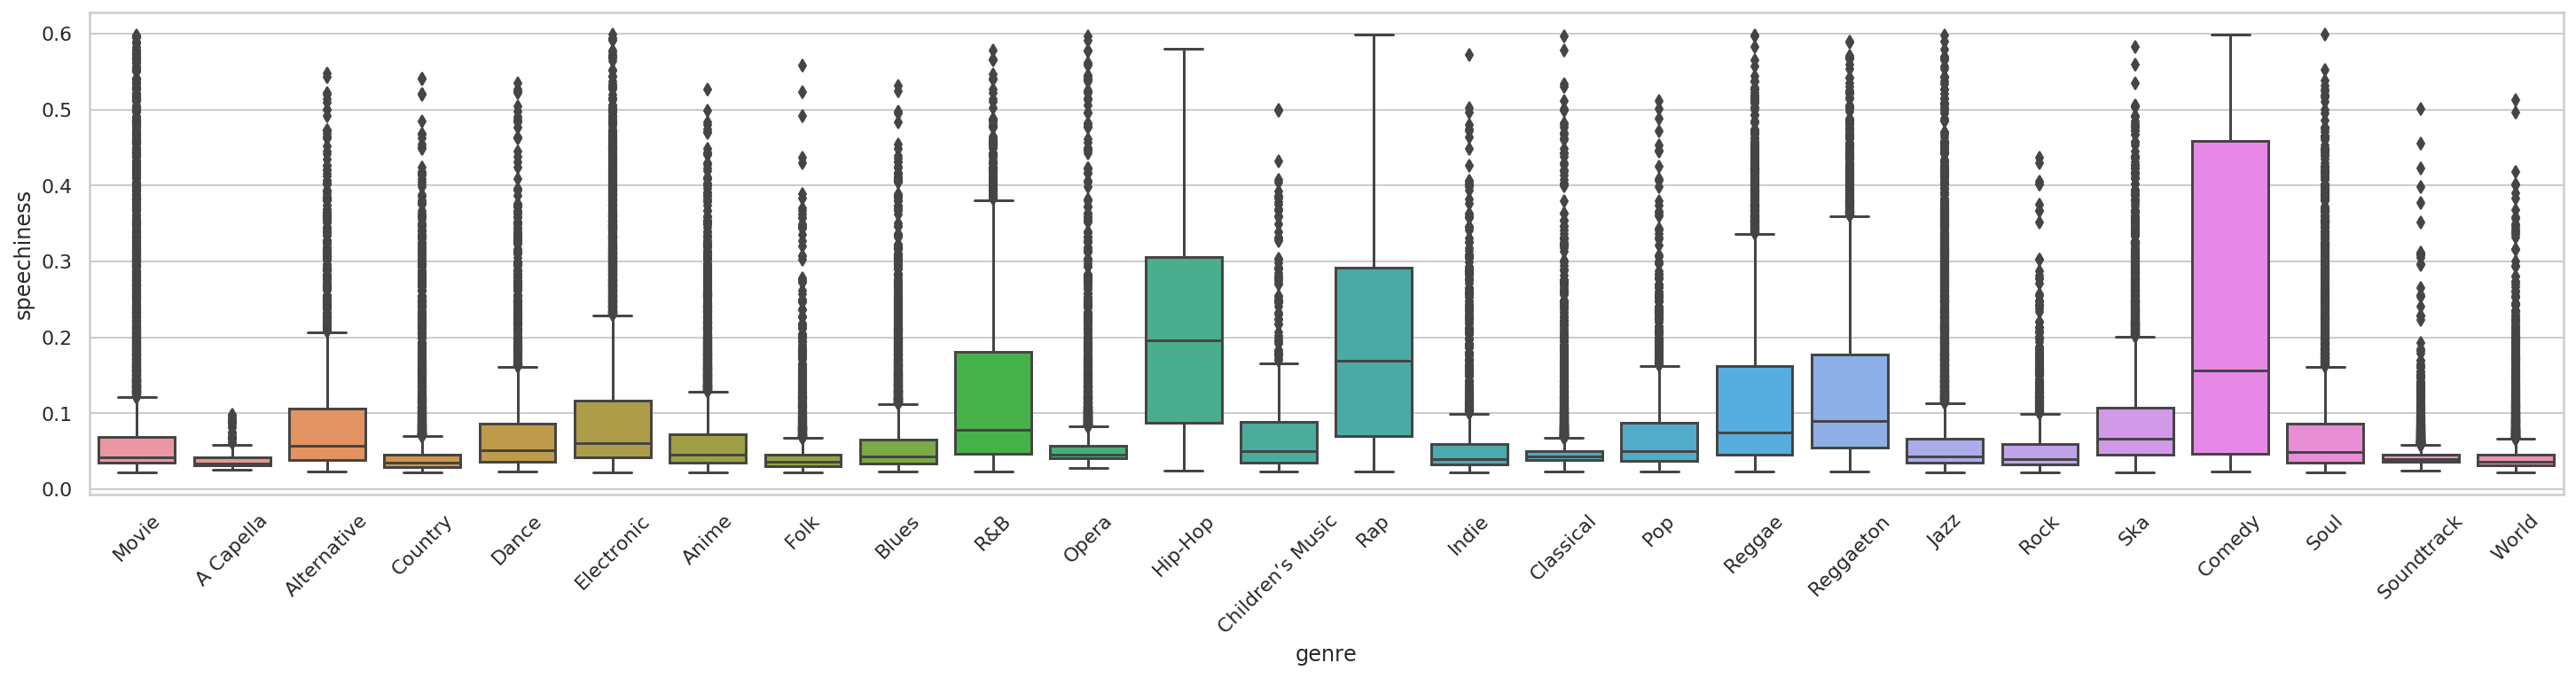

In [0]:
plt.figure(figsize=(25,5))
plt.xticks(rotation=45)
sns.boxplot(x='genre', y='speechiness', data=df)

That looks better.

NOTE: Later found out that Spotify claims "Values above 0.66 describe tracks that are probably made entirely of spoken words."

I was close!

https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/

# Feature Engineering Part 1

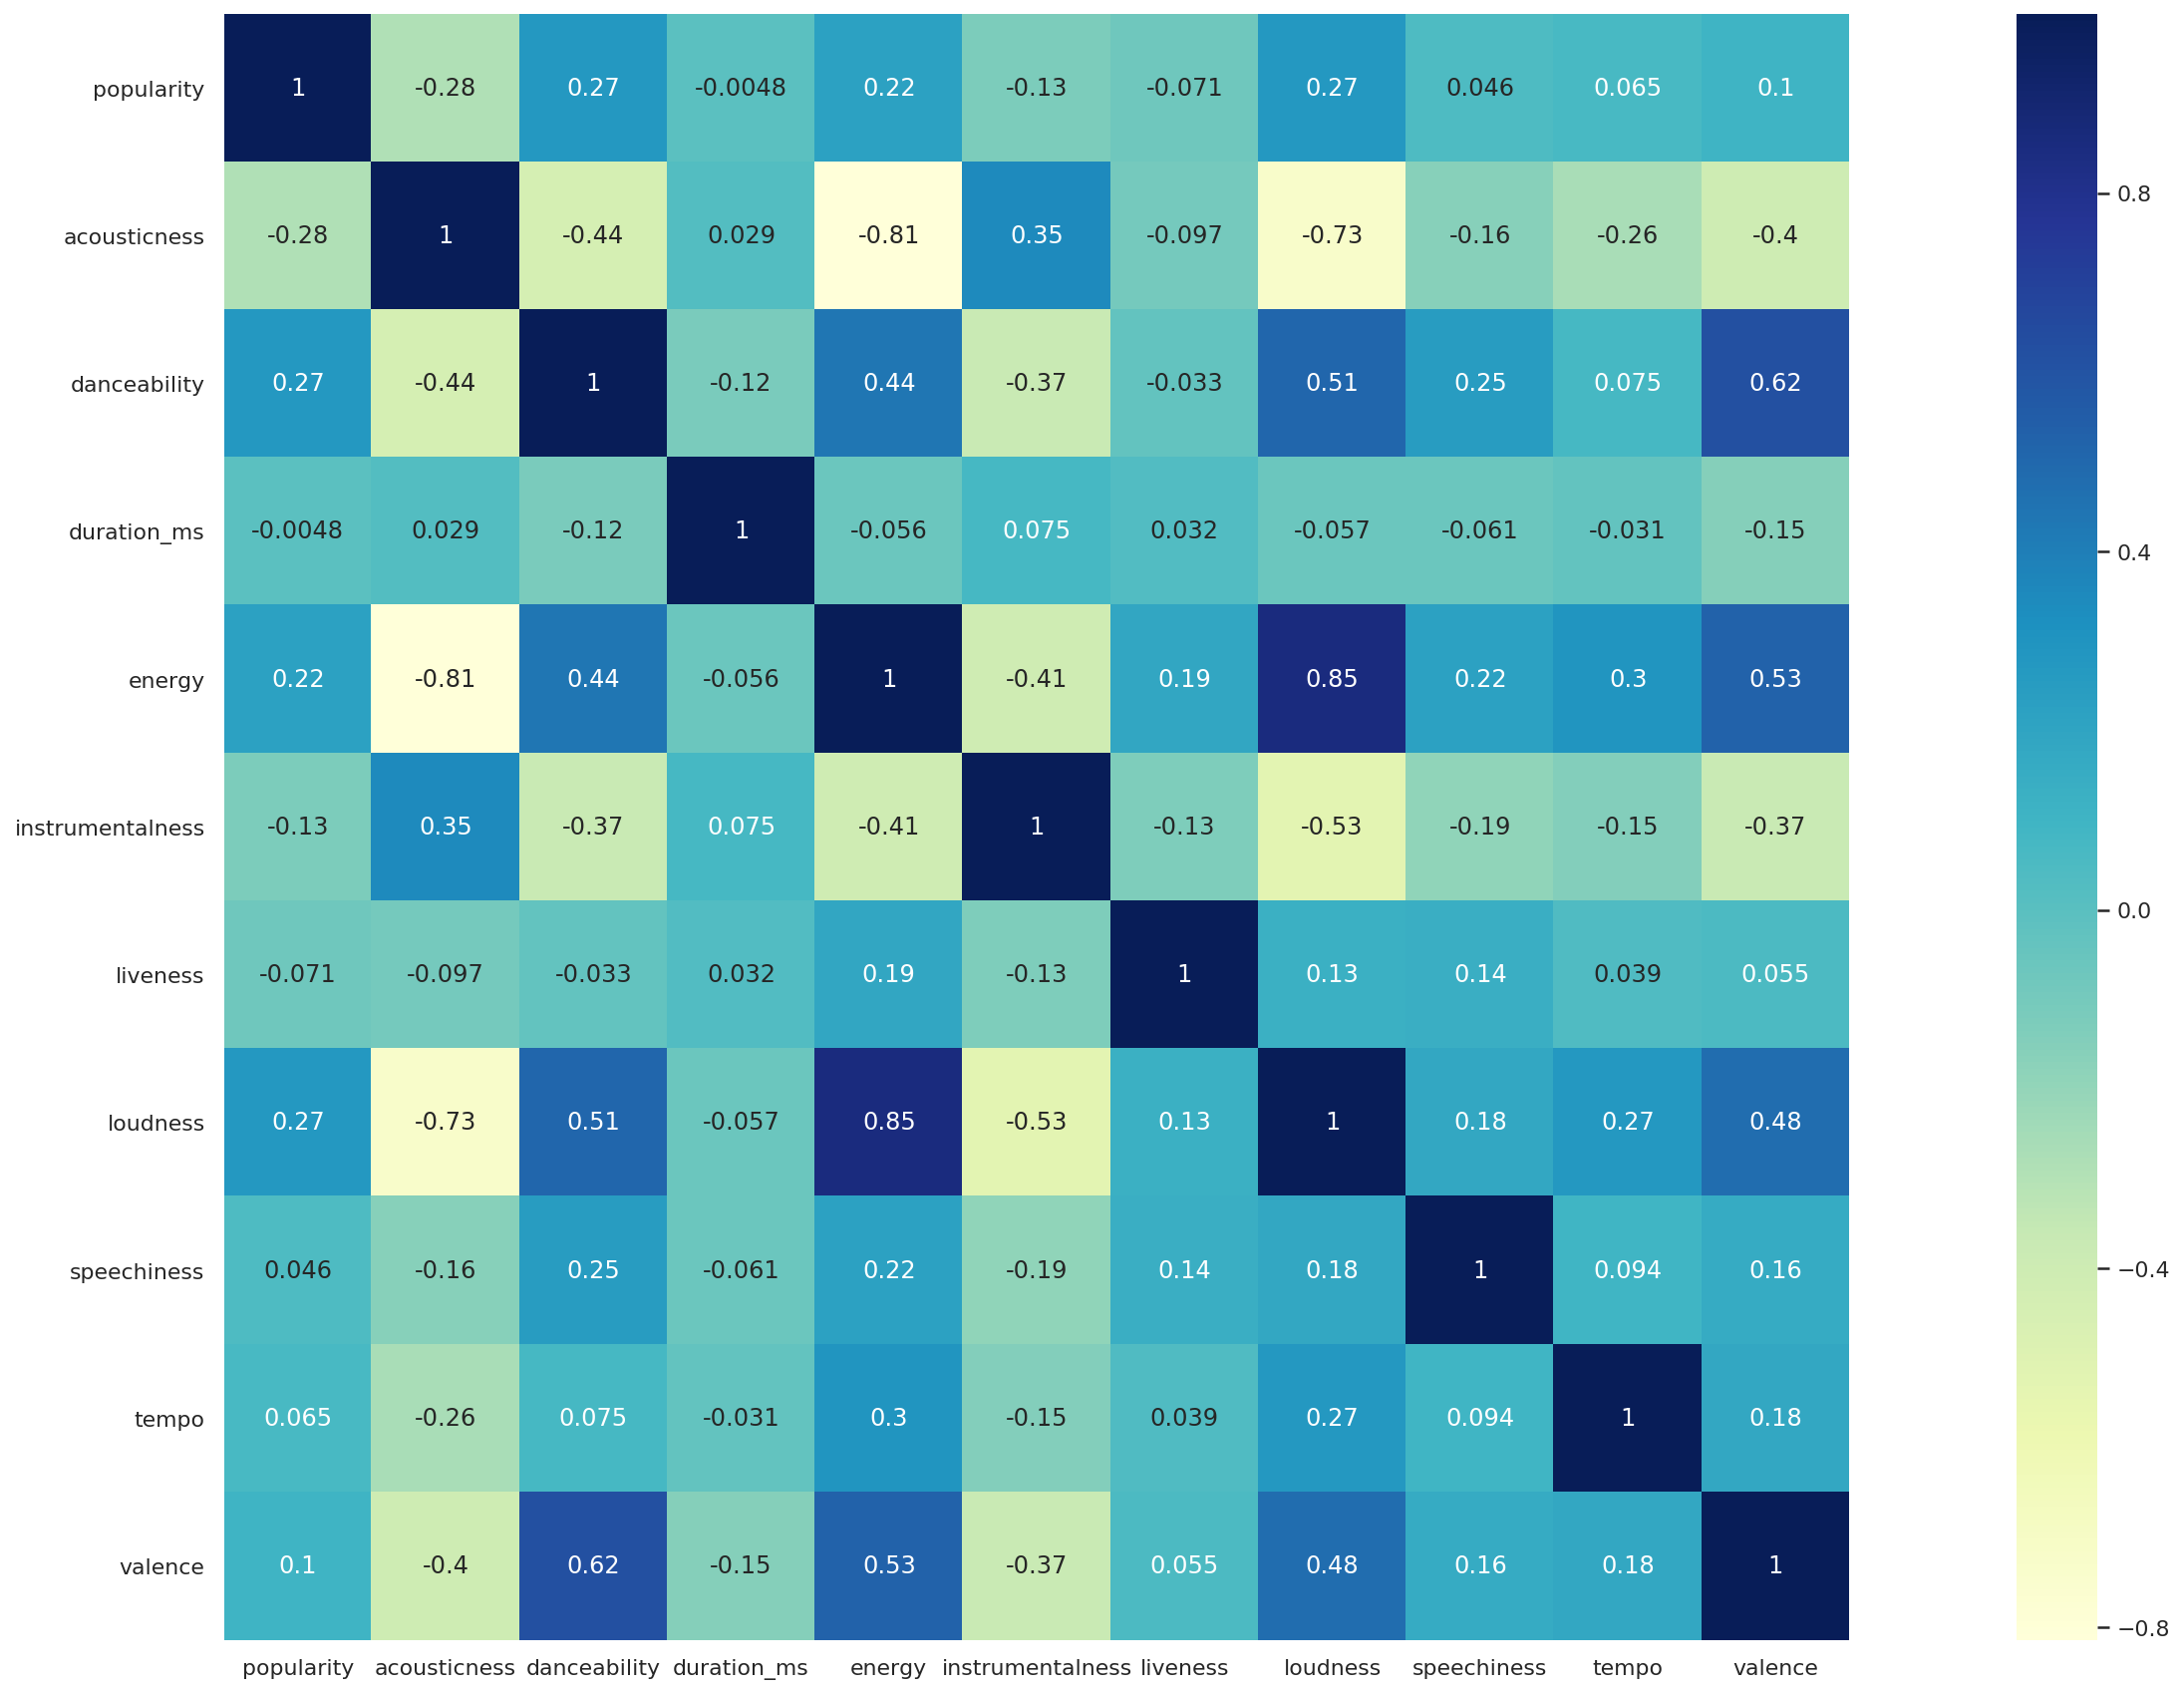

In [0]:
# produce heatmap
plt.figure(figsize=(30,15))
sns.heatmap(df.corr(), square=True, annot=True, cmap="YlGnBu")
plt.show()

Looking at our heatmap, it seems "energy" and "loudness" have a high correlation to eachother at 0.85. "Danceability" and "Valence" have a decently high correlation at 0.65, but I'll just deal with energy and valence for now since I'm usually looking for a 0.8 threshold.

## Correlated Features

Loudness is stored as a decibal value which ranges from negative to positive numbers. 

In [0]:
df.loudness.head()

0    -1.828
1    -5.559
2   -13.879
3   -12.178
4   -21.150
Name: loudness, dtype: float64

I'd like to scale these values from 0 to 1 to make things easier.

In [0]:
df.loudness -= df.loudness.min()
df.loudness /= df.loudness.max()

In [0]:
df.loudness.head()

0    0.900856
1    0.834469
2    0.686429
3    0.716695
4    0.557054
Name: loudness, dtype: float64

In [0]:
# combine energy and loudness into new 'power' attribute

df['power'] = df.energy * df.loudness

In [0]:
df = df.drop(columns=['energy', 'loudness'])

In [0]:
df.head()

genre        artist_name  ... valence     power
0  Movie     Henri Salvador  ...   0.814  0.819779
1  Movie  Martin & les fées  ...   0.816  0.615004
2  Movie    Joseph Williams  ...   0.368  0.089922
3  Movie     Henri Salvador  ...   0.227  0.233643
4  Movie       Fabien Nataf  ...   0.390  0.125337

[5 rows x 17 columns]

Before moving on to some modelling, I'd like to check one thing.

## Class Distribution

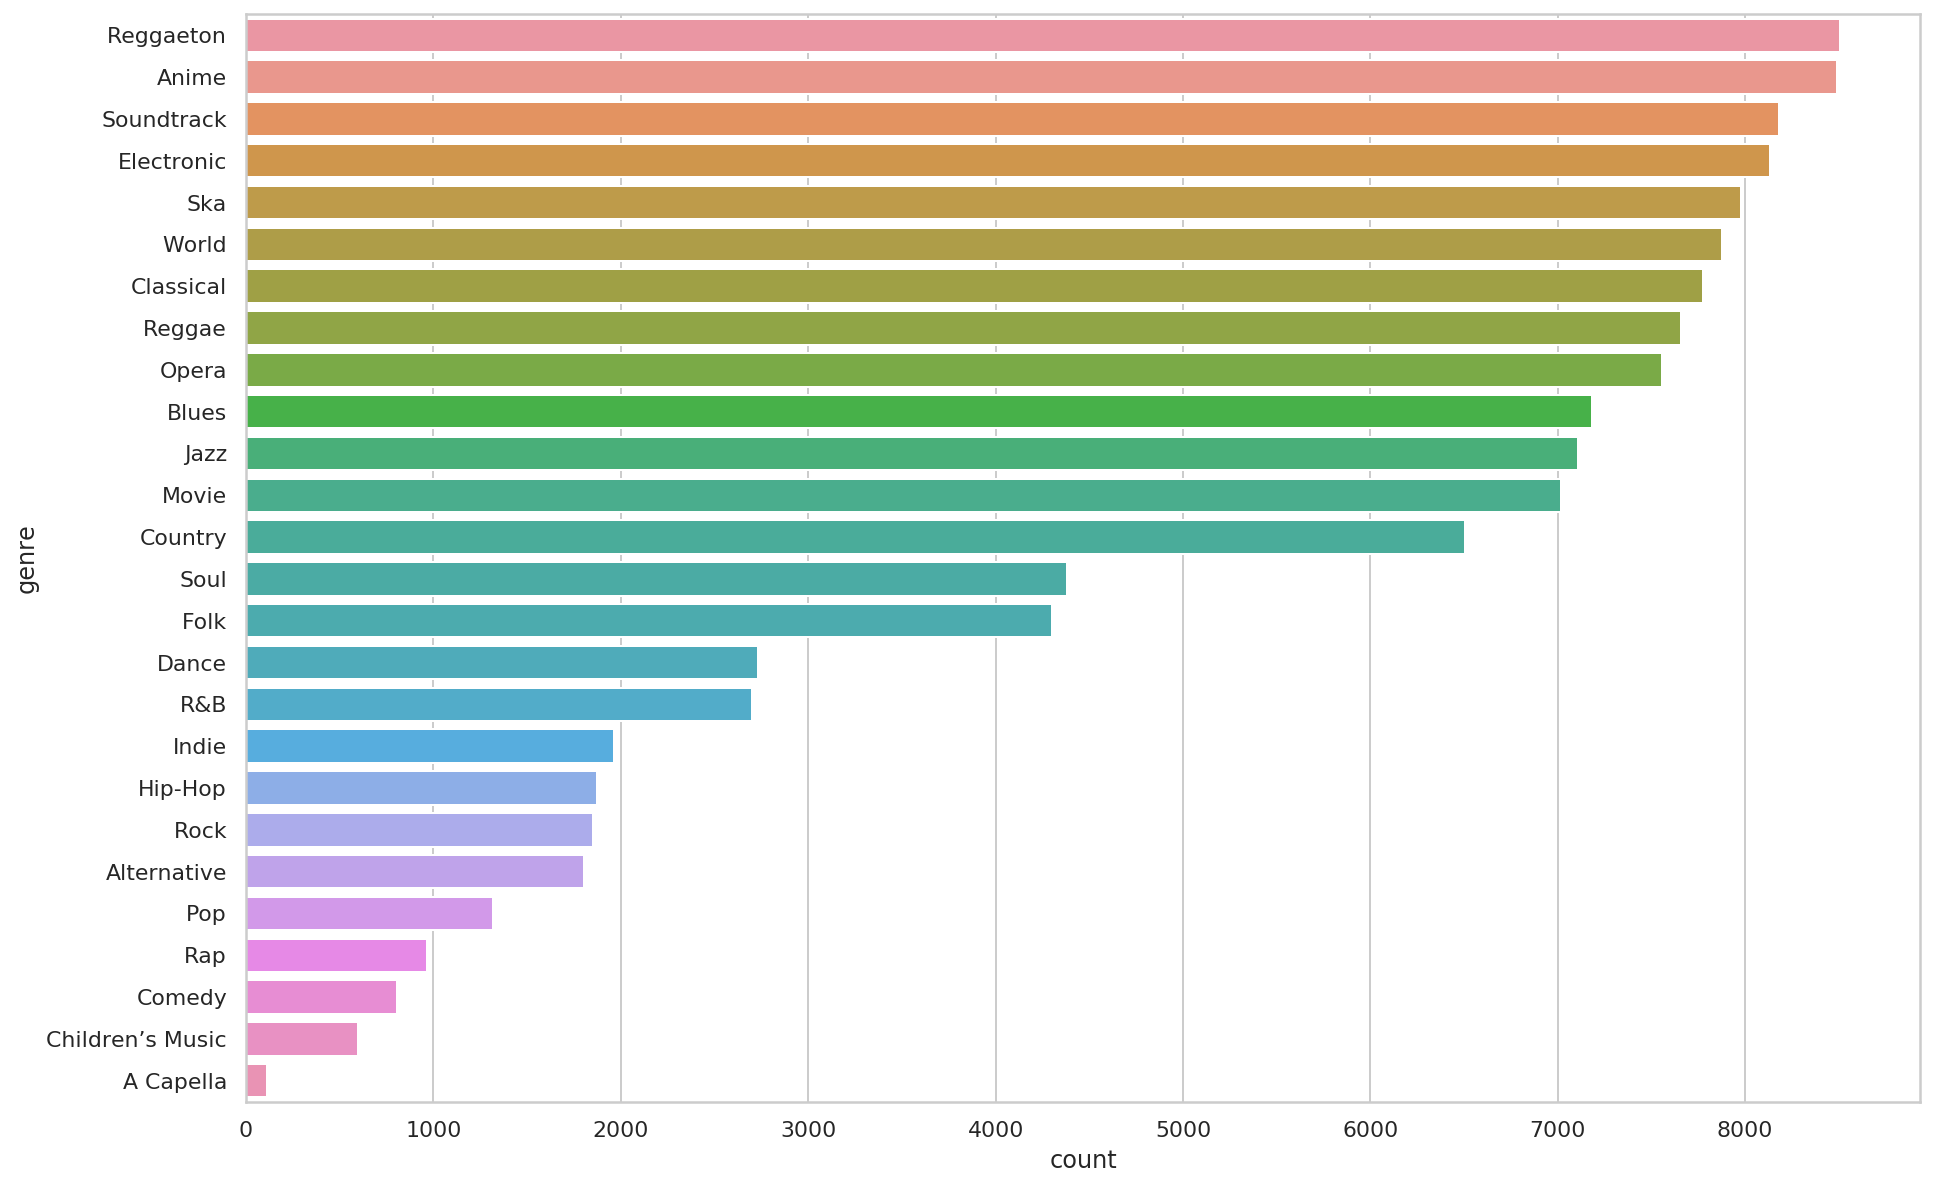

In [0]:
plt.figure(figsize=(15,10))
sns.countplot(y="genre", order=df.genre.value_counts().index, data=df)

As I suspected, removing the tracks with high speechiness unbalanced the classes quite a bit. It may be worth rebalancing the data, but we'd lose a lot of tracks. For now, let's skip that step.

Let's test some basic models to see where we're at.

# Modelling Part 1

I first need to encode the categorical rows "key", 'mode" and "time_signature".

## Label Encoding

In [0]:
def label_encode(data, cols):
    for col in cols:
        le = preprocessing.LabelEncoder()
        le.fit(data[col])
        data[col] = le.transform(data[col])
    return data

In [0]:
encode_cols = ['key', 'mode', 'time_signature']

In [0]:
df = label_encode(df, encode_cols)

In [0]:
df.head()

genre        artist_name  ... valence     power
0  Movie     Henri Salvador  ...   0.814  0.819779
1  Movie  Martin & les fées  ...   0.816  0.615004
2  Movie    Joseph Williams  ...   0.368  0.089922
3  Movie     Henri Salvador  ...   0.227  0.233643
4  Movie       Fabien Nataf  ...   0.390  0.125337

[5 rows x 17 columns]

## One-Hot Encoding

In [0]:
#def one_hot(data, dummies):
#   for dummy in dummies:
#       data = pd.concat([data, pd.get_dummies(data[dummy], prefix=[dummy])], axis=1)
#       data.drop([dummy], axis=1, inplace=True)
#   return data

In [0]:
#dummies = ['key', 'mode', 'time_signature']

In [0]:
#df = one_hot(df, dummies)

In [0]:
#df.head()

Next I'll remove the identifying features of the tracks which are unnecessary for modelling.

##Drop ID

I need to preserve the ID features for later modelling, so I'll use a copy for these models.

In [0]:
df2 = df.copy()

In [0]:
drop_list = ['artist_name', 'track_name', 'track_id']
df2 = df2.drop(columns=drop_list).reset_index(drop=True)

Let's set up some baseline tests for some different models, with default parameters.

In [0]:
def model_results(X, Y, model, name):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 123)
    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    prob_train = model.predict_proba(X_train)
    prob_test = model.predict_proba(X_test)

    print('{} train accuracy: {}'.format(name, accuracy_score(y_train, y_pred_train)))
    print('{} test accuracy: {}\n'.format(name, accuracy_score(y_test, y_pred_test)))

    print('{} train log loss: {}'.format(name, log_loss(y_train, prob_train)))
    print('{} test log loss: {}\n'.format(name, log_loss(y_test, prob_test)))

In [0]:
def baseline_test(X, Y):
    lr = LogisticRegression()
    model_results(X, Y, lr, 'logistic regression')
    
    rfc = RandomForestClassifier(random_state=123)
    model_results(X, Y, rfc, 'random forest classifier')
    
    knn = KNeighborsClassifier()
    model_results(X, Y, knn, 'k nearest neighbor')
    
    # takes a while
    gbc = GradientBoostingClassifier(n_estimators=200, random_state=123)
    model_results(X, Y, gbc, 'gradient boosting classifier')

## Baseline Test 1

In [0]:
scores = pd.DataFrame(np.array([['Logistic Regression', None, None], ['Random Forest', None, None], ['K Nearest Neighbor', None, None], ['Gradient Boosting', None, None]]),
                    columns=['Model Type', 'Train Accuracy', 'Test Accuracy'])

In [0]:
scores

Model Type Train Accuracy Test Accuracy
0  Logistic Regression           None          None
1        Random Forest           None          None
2   K Nearest Neighbor           None          None
3    Gradient Boosting           None          None

In [0]:
X = df2.drop(columns=['genre'])
Y = df2['genre']

In [0]:
baseline_test(X, Y)

random forest classifier train accuracy: 1.0
random forest classifier test accuracy: 0.5566677301004945

random forest classifier train log loss: 0.2783299399612924
random forest classifier test log loss: 1.764223916874572



In [0]:
#remove_genre = ['A Capella', 'Comedy', 'Pop', 'Alternative', 'Hip-Hop', 'Indie', 'R&B', 'Folk', 'Soul', 'Children’s Music', 'Dance', 'Rock', 'Rap', 'Movie', 'Soundtrack']

In [0]:
# remove genres

#for genre in remove_genre:
#    dropIndex = df2[df2.genre == genre].index
#    df2.drop(dropIndex, inplace=True)

In [0]:
#def limit_genres(x):
#    if (x in remove_genre):
#        x = 'Other'  
#    return x

In [0]:
#df2.genre = df2.genre.apply(limit_genres)

In [0]:
#plt.figure(figsize=(15,10))
#sns.countplot(y="genre", order=df2.genre.value_counts().index, data=df2)

In [0]:
#X = df2.drop(columns=['genre'])
#Y = df2['genre']

In [0]:
#baseline_test(X, Y)

# Feature Engineering Part 2

## Importing Data

In order to improve the models, I'm importing a dataset that contains data from over 1M artists, fetched from last.fm andmusicbrainz.com by user Piotr on kaggle.com https://www.kaggle.com/pieca111/music-artists-popularity

The feature of interest here is the artist's country of origin, which I believe will help to determine their music's genre.

In [0]:
# add 'artist data' dataset

ad = pd.read_csv('artists.csv')
ad.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2,4,6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


mbid  ... ambiguous_artist
0  cc197bad-dc9c-440d-a5b5-d52ba2e14234  ...            False
1  a74b1b7f-71a5-4011-9441-d0b5e4122711  ...            False
2  8bfac288-ccc5-448d-9573-c33ea2aa5c30  ...            False
3  73e5e69d-3554-40d8-8516-00cb38737a1c  ...            False
4  b95ce3ff-3d05-4e87-9e01-c97b66af13d4  ...            False

[5 rows x 10 columns]

In [0]:
# check for missing data

ad.isnull().sum().sort_values(ascending=False).head(20)

tags_mb             1346137
country_lastfm      1254585
tags_lastfm         1085008
country_mb           803715
artist_lastfm        479327
scrobbles_lastfm     479323
listeners_lastfm     479323
artist_mb                 8
ambiguous_artist          0
mbid                      0
dtype: int64

I will use country_mb (musicbrainz.com) as opposed to country_lastfm since it has significantly less null values.

In [0]:
# condense to the features i need

artist_country = ad[['artist_mb', 'country_mb']]

artist_country.head()

artist_mb      country_mb
0               Coldplay  United Kingdom
1              Radiohead  United Kingdom
2  Red Hot Chili Peppers   United States
3                Rihanna   United States
4                 Eminem   United States

In [0]:
# check for duplicates

dups_total = artist_country[artist_country.duplicated(subset = 'artist_mb', keep=False)]
dups_unique = artist_country[artist_country.duplicated(subset = 'artist_mb', keep='first')]

print(len(dups_total), 'total duplicates')
print(len(dups_unique), 'unique duplicates')

168138 total duplicates
113086 unique duplicates


In [0]:
# drop duplicates

artist_country.drop_duplicates(subset='artist_mb', keep='first', inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
# confirm duplicates removed

dups_total = artist_country[artist_country.duplicated(subset = 'artist_mb', keep=False)]
dups_unique = artist_country[artist_country.duplicated(subset = 'artist_mb', keep='first')]

print(len(dups_total), 'total duplicates')
print(len(dups_unique), 'unique duplicates')

0 total duplicates
0 unique duplicates


In [0]:
# check for missing values

artist_country.isnull().sum().sort_values(ascending=False).head(20)

country_mb    755955
artist_mb          1
dtype: int64

In [0]:
# drop missing values

artist_country.dropna(axis=0, subset=['artist_mb', 'country_mb'], inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
# merge data

df = pd.merge(df, artist_country, left_on='artist_name', right_on='artist_mb')

In [0]:
df.head()

genre     artist_name  ...       artist_mb country_mb
0  Movie  Henri Salvador  ...  Henri Salvador     France
1  Movie  Henri Salvador  ...  Henri Salvador     France
2  Movie  Henri Salvador  ...  Henri Salvador     France
3  Movie  Henri Salvador  ...  Henri Salvador     France
4  Movie  Henri Salvador  ...  Henri Salvador     France

[5 rows x 19 columns]

In [0]:
df[['genre', 'artist_name', 'track_name', 'country_mb']][20002:20007]

genre  ...      country_mb
20002  Electronic  ...         Iceland
20003  Electronic  ...          Sweden
20004  Electronic  ...         Romania
20005  Electronic  ...         Romania
20006  Electronic  ...  Czech Republic

[5 rows x 4 columns]

Success!

In [0]:
# drop redundant 'artist_mb' column

df = df.drop(columns=['artist_mb'])

Let's check out the distributions of artist's countries.

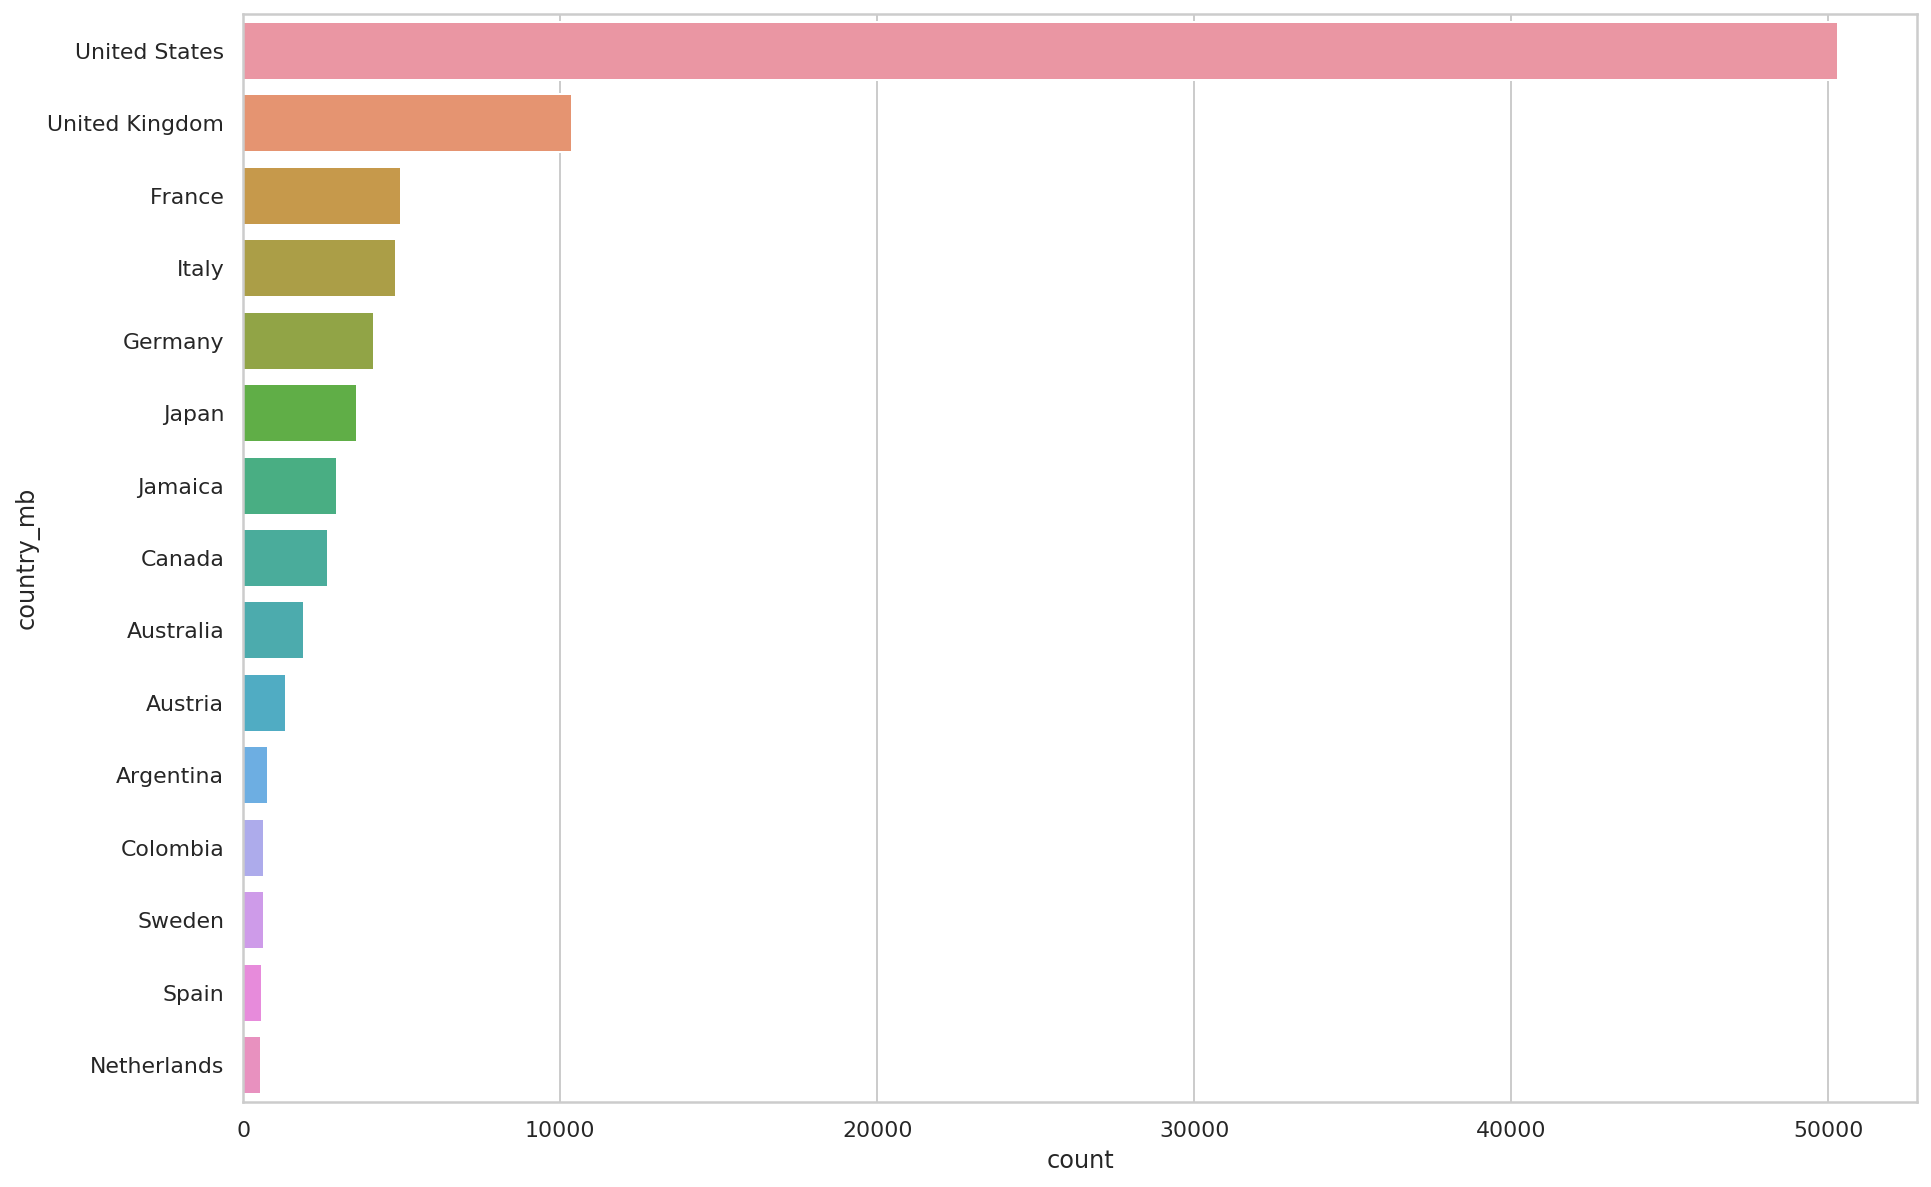

In [0]:
# get artist country distribution

plt.figure(figsize=(15,10))
sns.countplot(y="country_mb", order=df.country_mb.value_counts().head(15).index, data=df, orient='v')

In [0]:
df.country_mb.nunique()

111

In [0]:
#dfx = df.copy()

In [0]:
#def limit_countries(x):
#   top_countries = ['United States', 'United Kingdom', 'France', 'Italy', 'Germany', 'Japan', 'Jamaica', 'Canada', 'Australia', 'Austria']
#   if (x not in top_countries):
#        x = 'Other'  
#   return x

In [0]:
# top 10 countries

#dfx.country_mb = dfx.country_mb.apply(limit_countries)

In [0]:
#dfx.country_mb.nunique()

In [0]:
# get artist country distribution

#plt.figure(figsize=(15,10))
#sns.countplot(y="country_mb", order=dfx.country_mb.value_counts().index, data=dfx, orient='v')

The United States is clearly the most common country. Hopefully that won't hinder the effectiveness of the new feature too severely.

I'll try out the models again with the new feature.

# Modelling Part 2

Label encode artist country feature.

In [0]:
cols = ['country_mb']

In [0]:
df = label_encode(df, cols)

In [0]:
df.head()

genre     artist_name  ...     power country_mb
0  Movie  Henri Salvador  ...  0.819779         37
1  Movie  Henri Salvador  ...  0.233643         37
2  Movie  Henri Salvador  ...  0.063233         37
3  Movie  Henri Salvador  ...  0.382021         37
4  Movie  Henri Salvador  ...  0.654605         37

[5 rows x 18 columns]

Drop the IDs again.

In [0]:
drop_list = ['artist_name', 'track_name', 'track_id']
df = df.drop(columns=drop_list).reset_index(drop=True)

## Baseline Test 2

In [0]:
X = df.drop(columns=['genre'])
Y = df['genre']

In [0]:
baseline_test(X, Y)

random forest classifier train accuracy: 1.0
random forest classifier test accuracy: 0.6394260761072988

random forest classifier train log loss: 0.24175241615639267
random forest classifier test log loss: 1.5083078723433512



Now all that's left is to optimize these models.

# Model Optimization

In [0]:
# produce heatmap
#plt.figure(figsize=(30,15))
#sns.heatmap(df.corr(), square=True, annot=True, cmap="YlGnBu")
#plt.show()

My goal here is to optomize the parameters of the random forest classifier, since it is the best performing model.

In [0]:
X = df.drop(columns=['genre'])
Y = df['genre']

In [0]:
baseline_test(X, Y)

random forest classifier train accuracy: 1.0
random forest classifier test accuracy: 0.6394260761072988

random forest classifier train log loss: 0.24175241615639267
random forest classifier test log loss: 1.5083078723433512



## GridSearch

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 123)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 76942
The number of observations in test set is 19236


In [0]:
rfc = RandomForestClassifier(random_state=123)

In [0]:
parameter_candidates = {'n_estimators': [50, 100, 150], 
                  'max_depth':  [None, 2, 5, 10],
                  'min_samples_split': [1, 2, 3], 
                  'min_samples_leaf': [1, 2, 3], 
                  'criterion': ['gini', 'entropy'],
                  'bootstrap': [True, False]
}

In [0]:
rf_gs = GridSearchCV(estimator=rfc, param_grid=parameter_candidates, cv=5, n_jobs=-1, verbose=1)

In [0]:
#rf_gs.fit(X_train, y_train)

In [0]:
#rf_gs.best_score_

In [0]:
#rf_gs.best_params_

In [0]:
#model_results(rf_gs, 'best rforest grid')

In [0]:
rf_random_params = {'n_estimators': np.arange(100, 1050, 50), 
                  'max_depth':  np.arange(2, 10), 
                  'min_samples_split': [2,5,7,10,12,15,17,20], 
                  'min_samples_leaf': [2,5,7,10,12,15,17,20], 
                  'max_features': ['auto', 'sqrt', 'log2'], 
                  'bootstrap': [True, False]
}

In [0]:
rf_rg = RandomizedSearchCV(estimator=rfc, param_distributions=rf_random_params, n_iter = 50, cv = 3, verbose = 1, n_jobs = -1, random_state=123)

In [0]:
#rf_rg.fit(X_train, y_train)

In [0]:
#y_pred = rf_rg.predict(X_test)

In [0]:
#rf_rg.best_score_

In [0]:
#rf_rg.best_params_

In [0]:
#model_results(X, Y, rf_rg, 'rforest')

In [0]:
#from sklearn.metrics import classification_report
#print(classification_report(y_test, y_pred))

## Plots

https://scikit-plot.readthedocs.io/en/stable/Quickstart.html

In [0]:
X = df.drop(columns=['genre'])
Y = df['genre']

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 123)

In [0]:
rfc = RandomForestClassifier(random_state=123)

In [0]:
predictions = cross_val_predict(rfc, X, Y)

<Figure size 2160x1080 with 0 Axes>

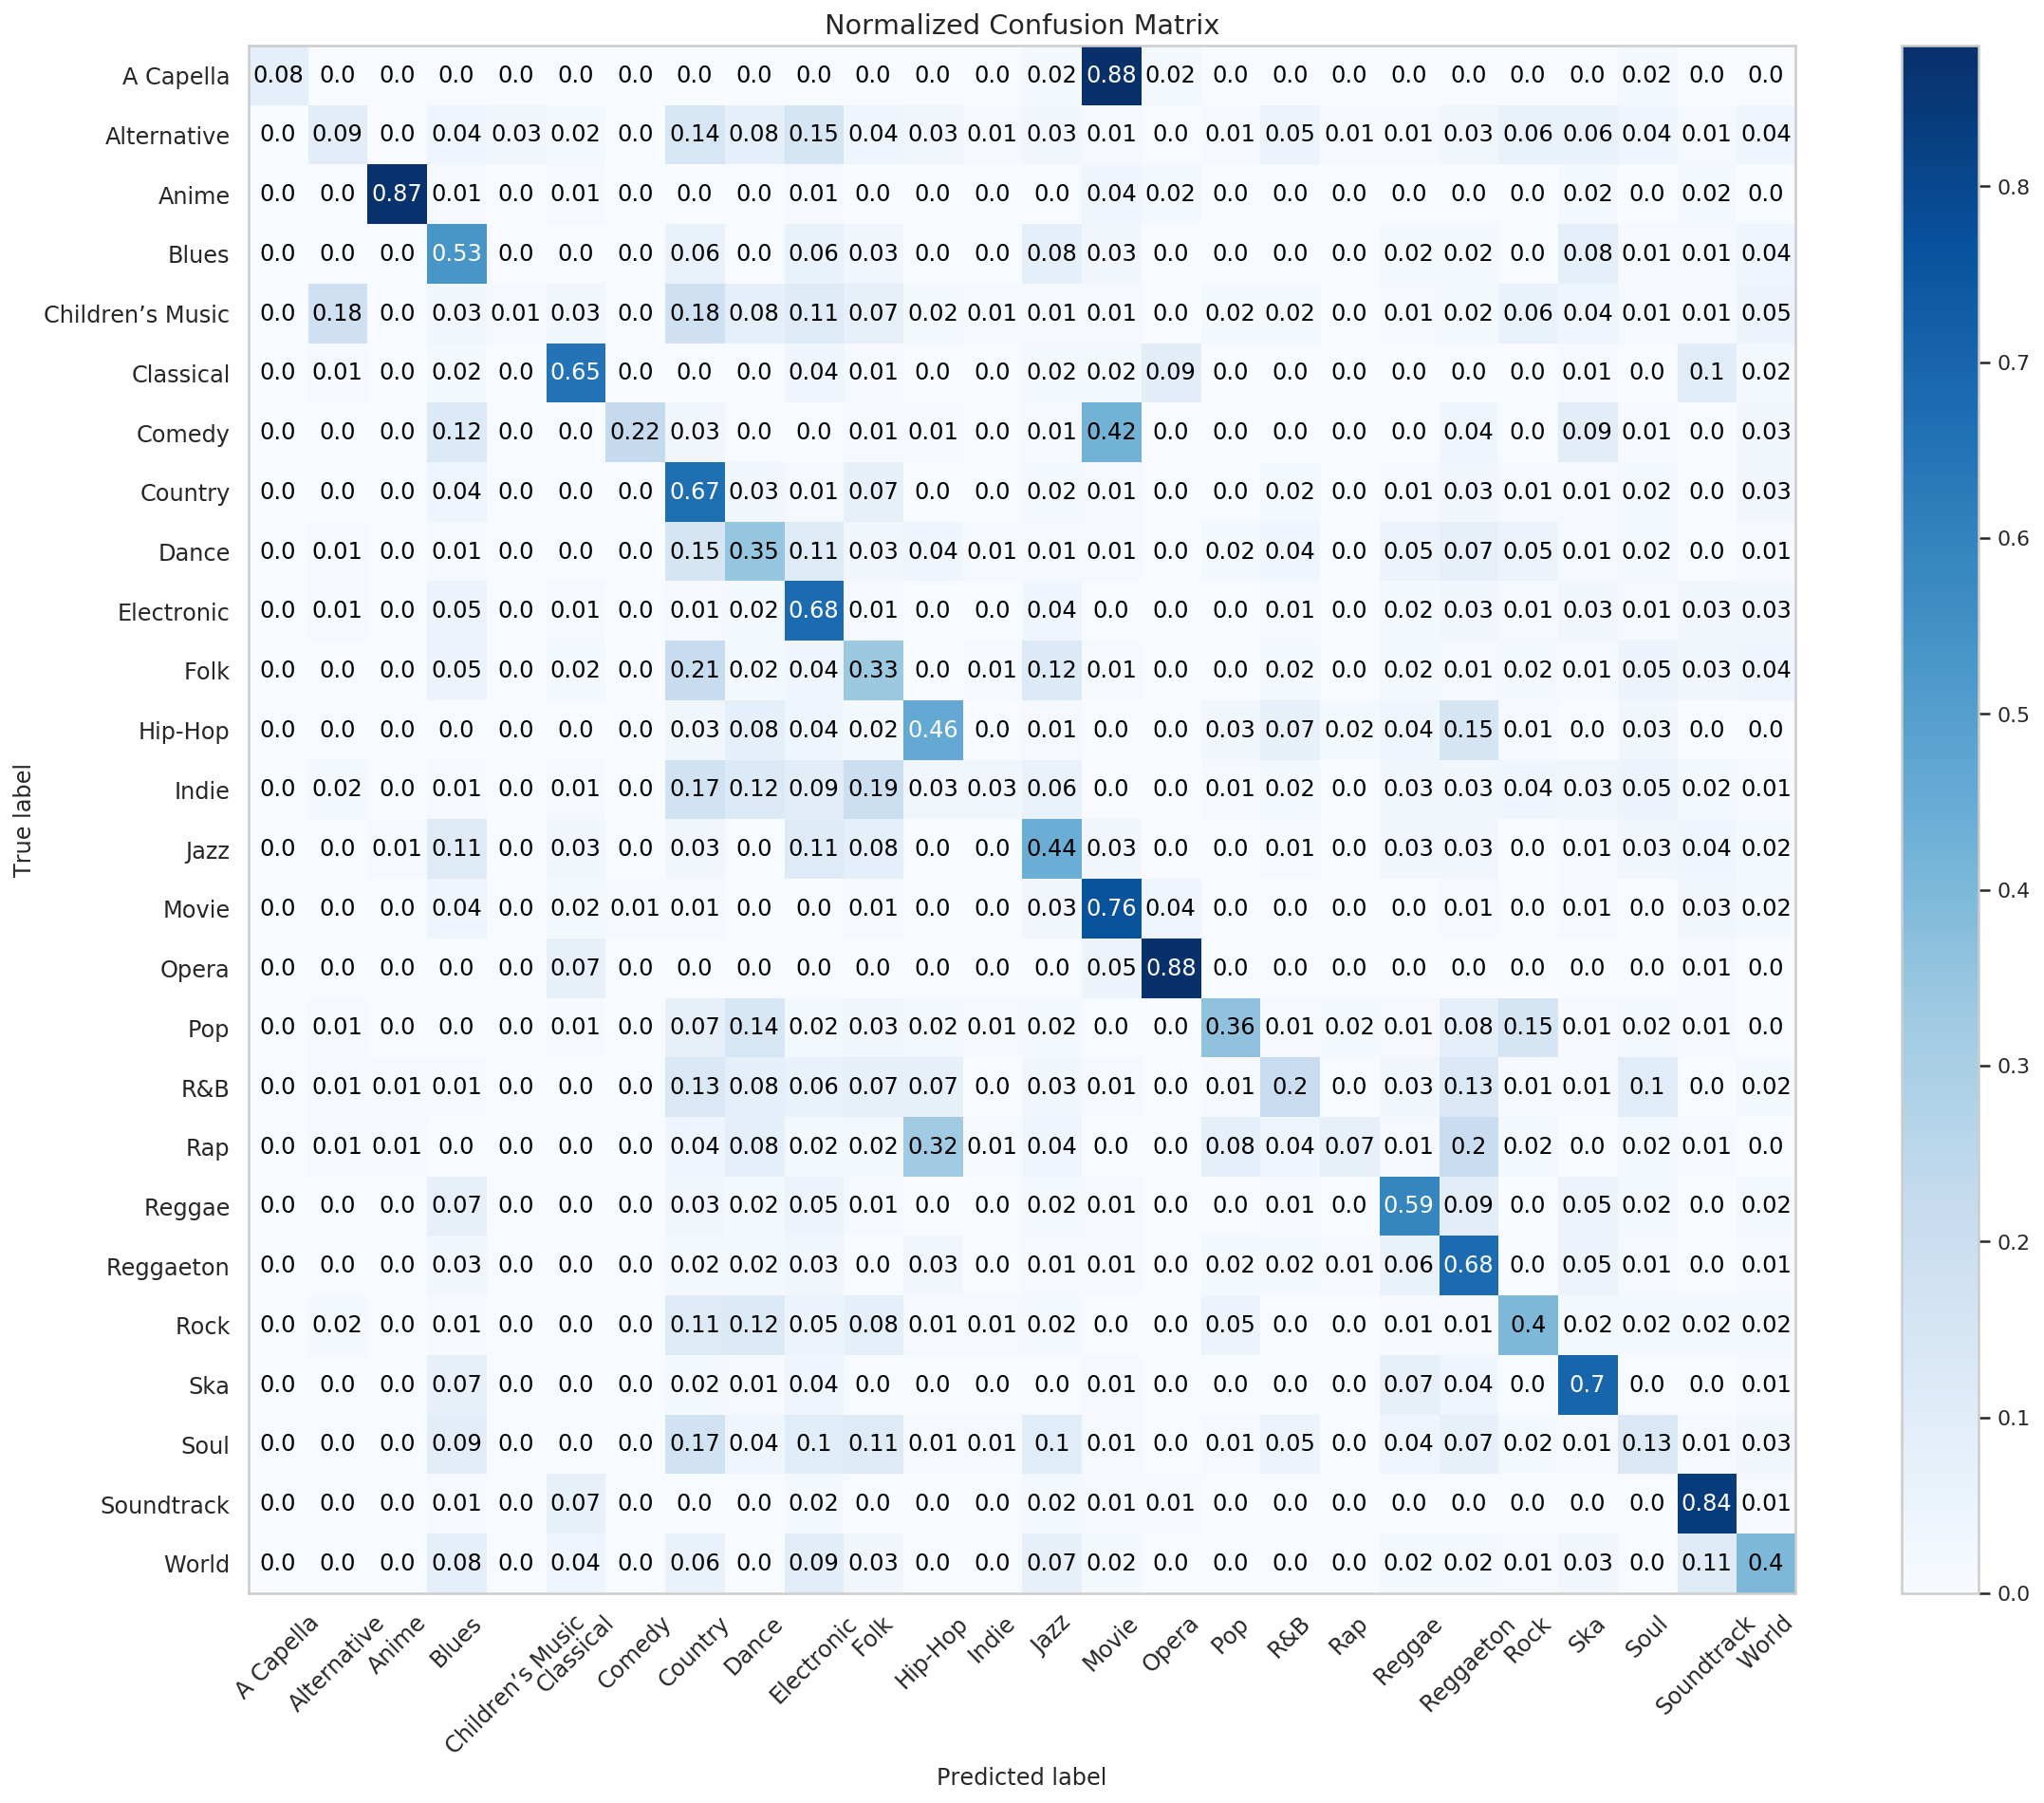

In [0]:
plt.figure(figsize=(30,15))
skplt.metrics.plot_confusion_matrix(Y, predictions, normalize=True, x_tick_rotation=45, figsize=(20,15))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=FutureWarning)


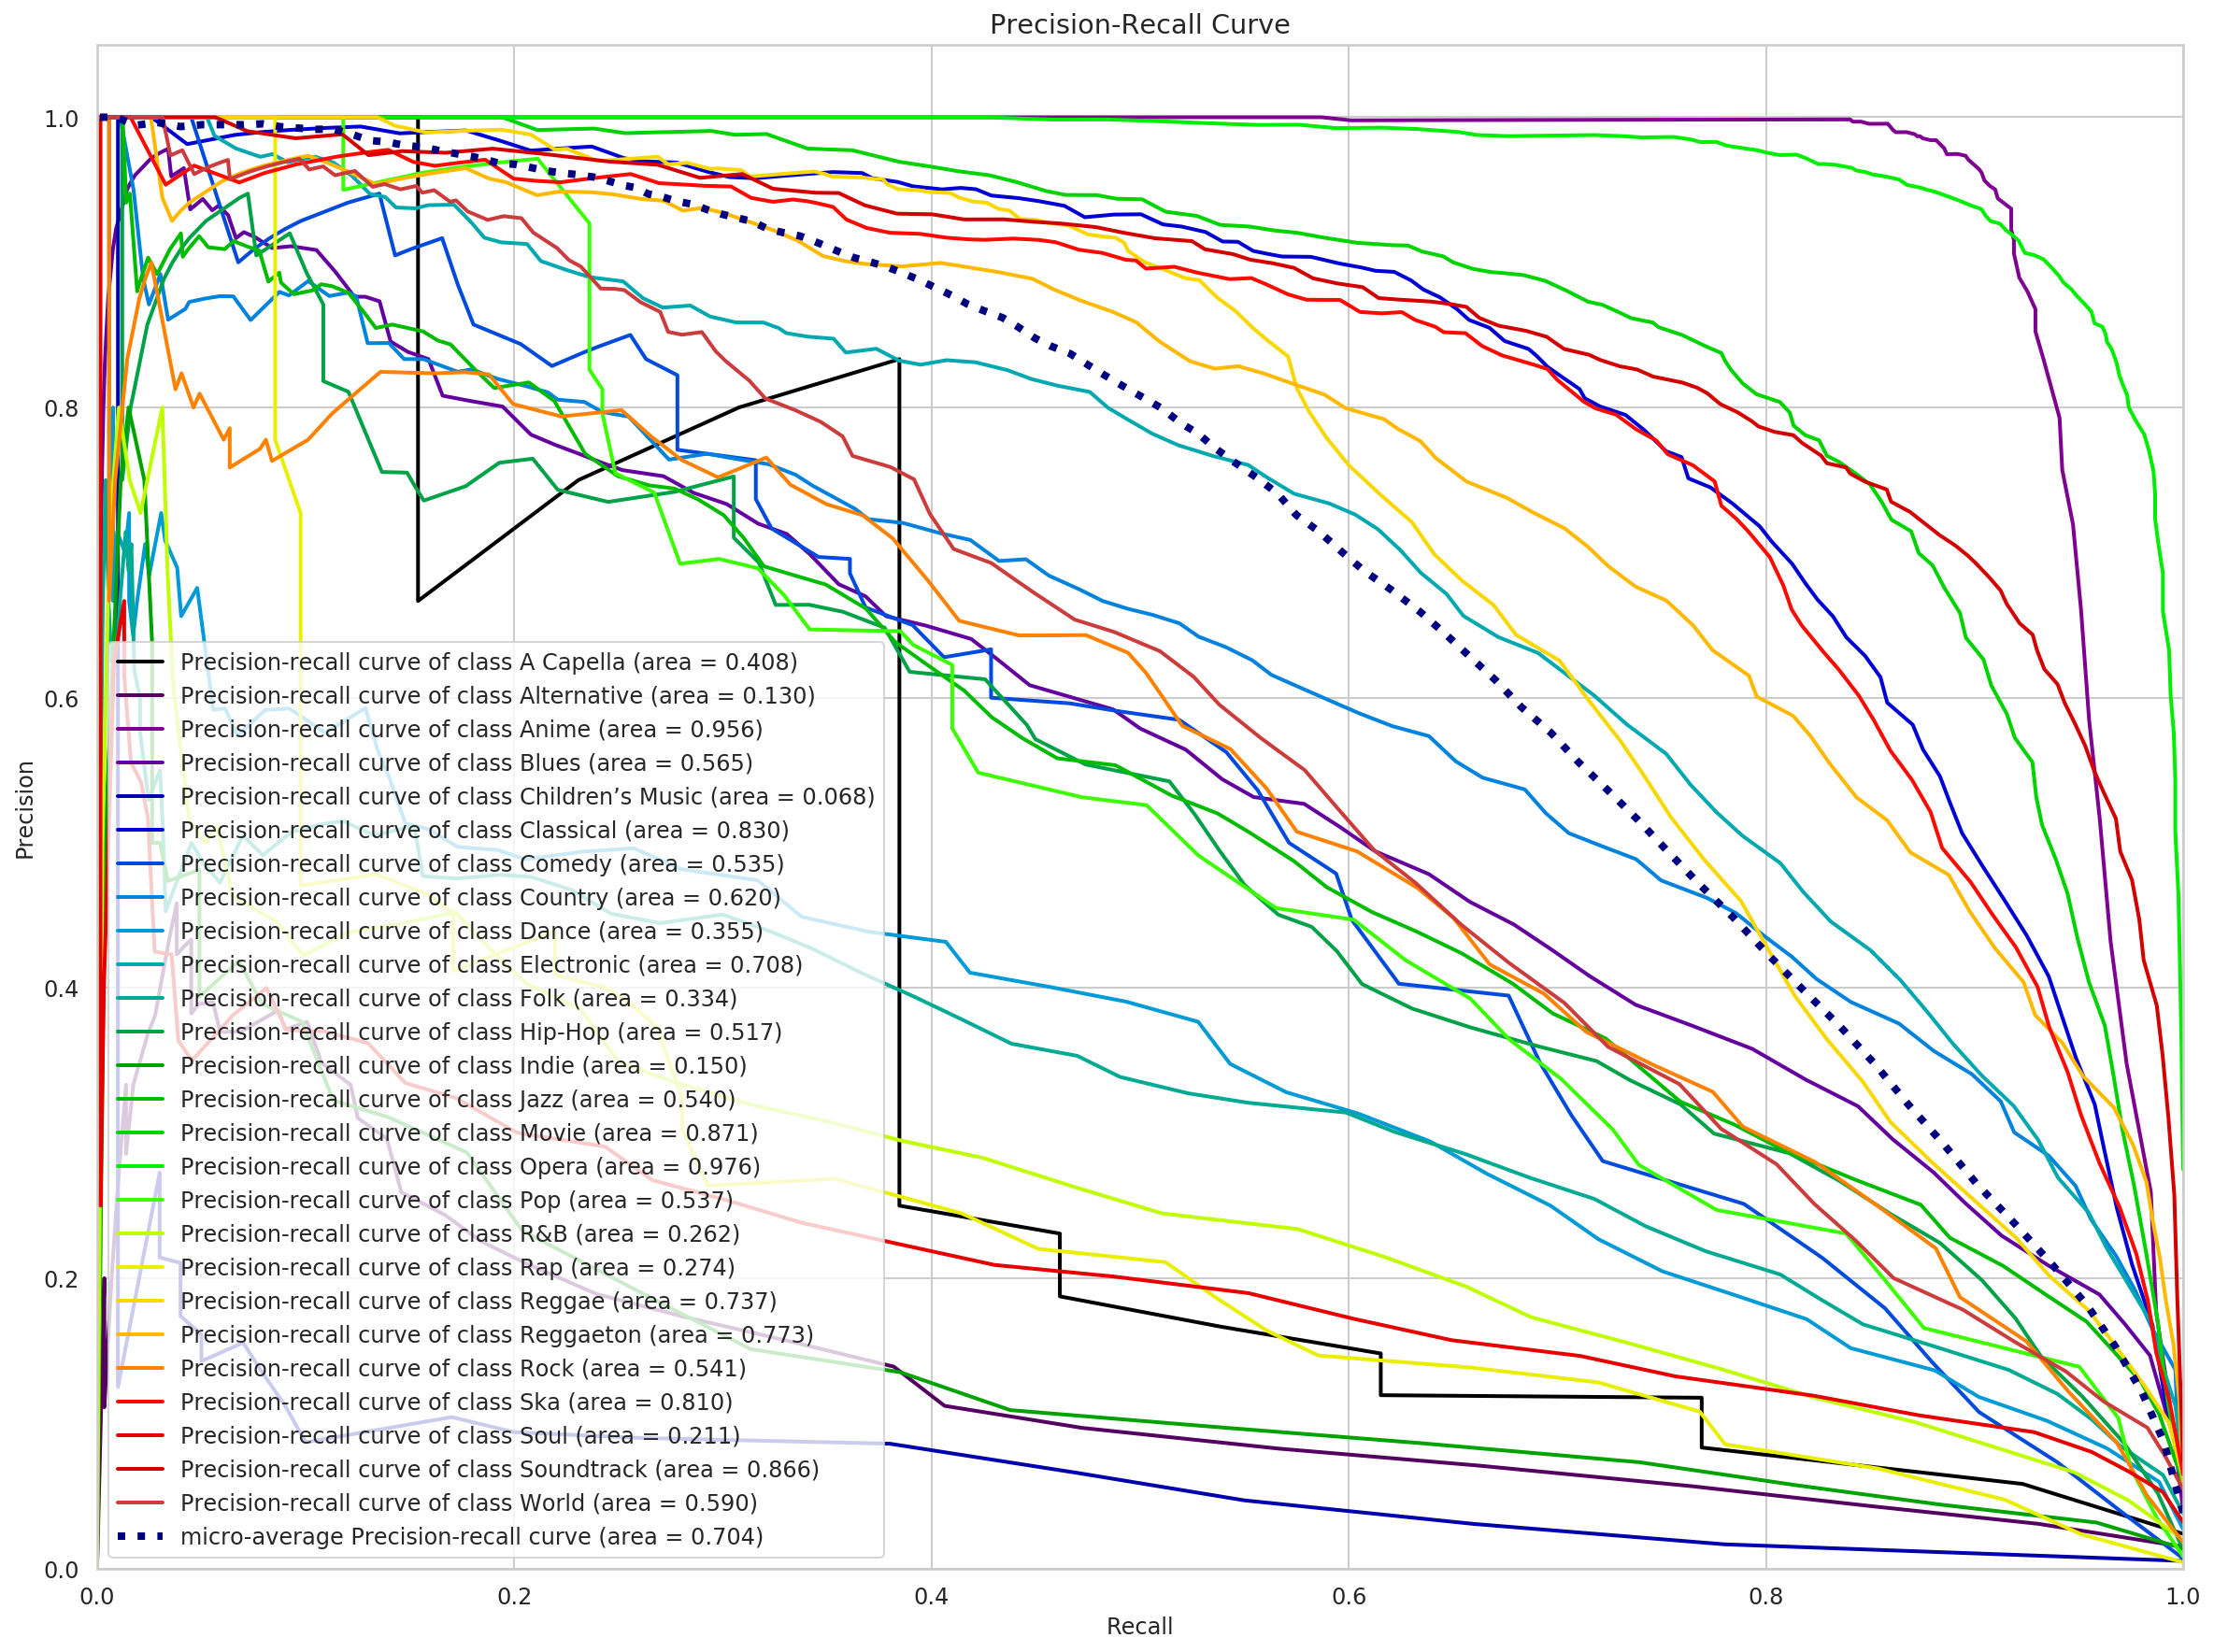

In [0]:
#plt.figure(figsize=(30,15))
rfc.fit(X_train, y_train)
probas = rfc.predict_proba(X_test)
skplt.metrics.plot_precision_recall_curve(y_test, probas, figsize=(20,15))
plt.show()

## Remove Classes

In [0]:
# preserve original dataframe

df_rem = df.copy() # remove genres

Let's iteratively reduce the amount of classes by half and see how the model improves each time.

In [0]:
def remove_genre(data, genres):
    for genre in genres:
        dropIndex = data[data.genre == genre].index
        data.drop(dropIndex, inplace=True)
    return data

In [0]:
def accuracy_plots(X, Y):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 123)
    rfc = RandomForestClassifier(random_state=123)
    predictions = cross_val_predict(rfc, X, Y)

    skplt.metrics.plot_confusion_matrix(Y, predictions, normalize=True, x_tick_rotation=45, figsize=(10,10))

    rfc.fit(X_train, y_train)
    probas = rfc.predict_proba(X_test)
    skplt.metrics.plot_precision_recall_curve(y_test, probas, figsize=(10,10))

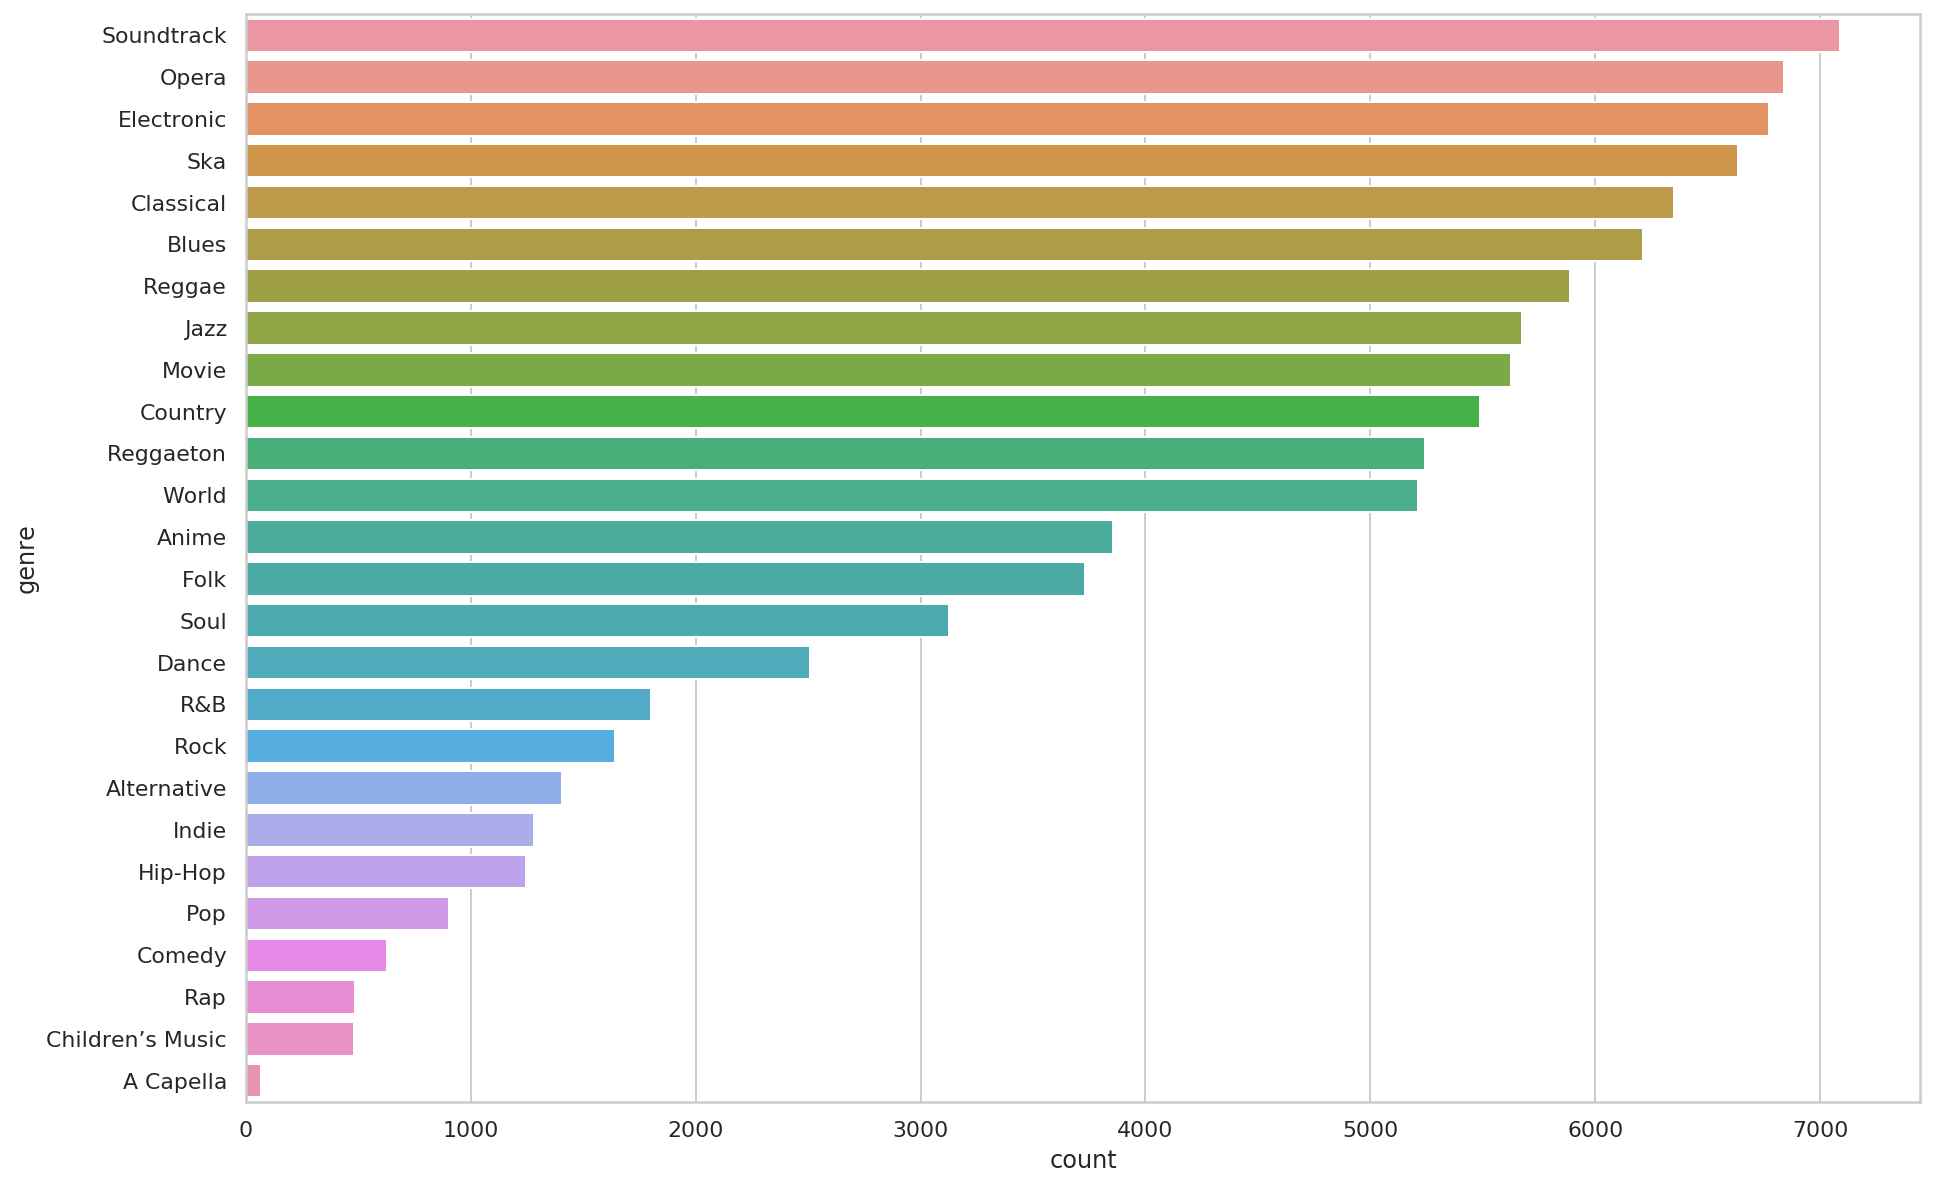

In [0]:
plt.figure(figsize=(15,10))
sns.countplot(y="genre", order=df_rem.genre.value_counts().index, data=df_rem)

In [0]:
df_rem.genre.nunique()

26

In [0]:
# remove 13
remove = ['A Capella', 'Children’s Music', 'Rap', 'Comedy', 'Pop', 'Hip-Hop', 'Indie', 'Alternative', 'Rock', 'R&B', 'Dance', 'Soul', 'Folk']

In [0]:
df_rem = remove_genre(df_rem, remove)

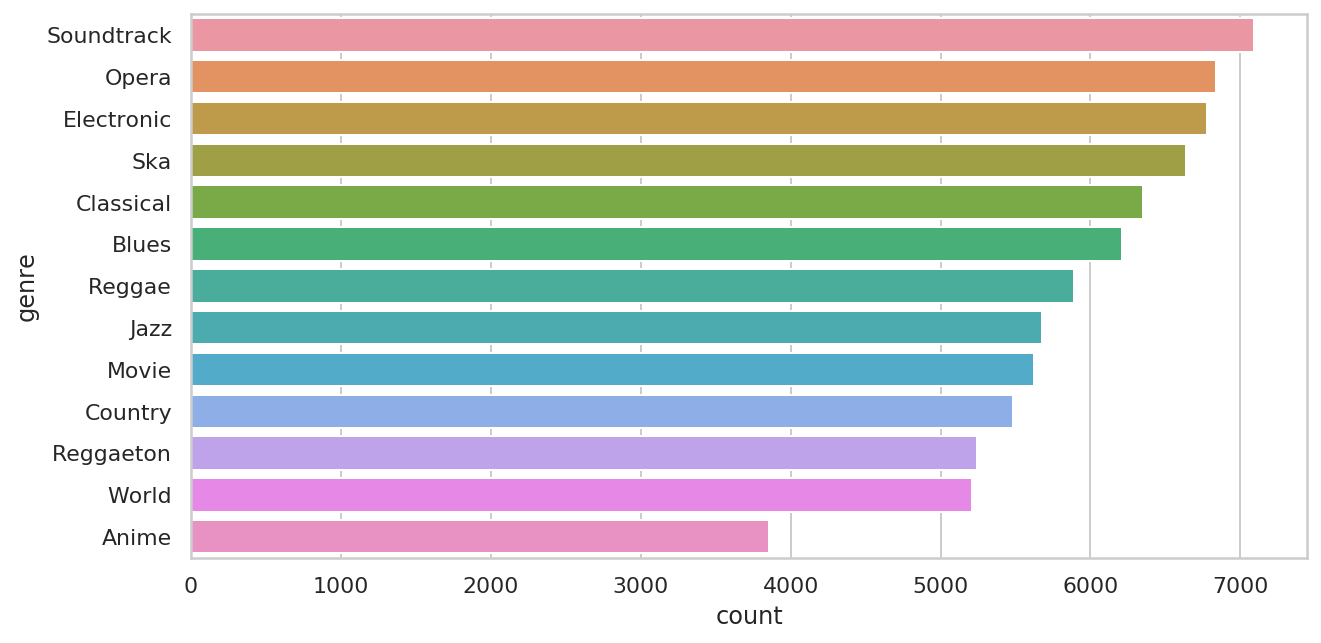

In [0]:
plt.figure(figsize=(10,5))
sns.countplot(y="genre", order=df_rem.genre.value_counts().index, data=df_rem)

In [0]:
df_rem.genre.nunique()

13

In [0]:
X = df_rem.drop(columns=['genre'])
Y = df_rem['genre']

In [0]:
baseline_test(X, Y)

logistic regression train accuracy: 0.17846458997203615
logistic regression test accuracy: 0.1767574949600052

logistic regression train log loss: 2.404748153055931
logistic regression test log loss: 2.4049040454936867

random forest classifier train accuracy: 1.0
random forest classifier test accuracy: 0.7504714833842752

random forest classifier train log loss: 0.189114858226372
random forest classifier test log loss: 0.8869113275562888

k nearest neighbor train accuracy: 0.42591207647785656
k nearest neighbor test accuracy: 0.18046432984327243

k nearest neighbor train log loss: 1.2290165633108223
k nearest neighbor test log loss: 17.475539131463403

gradient boosting classifier train accuracy: 0.7861741562073227
gradient boosting classifier test accuracy: 0.7492358717565195

gradient boosting classifier train log loss: 0.6466133227253291
gradient boosting classifier test log loss: 0.7484222506169974



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=FutureWarning)


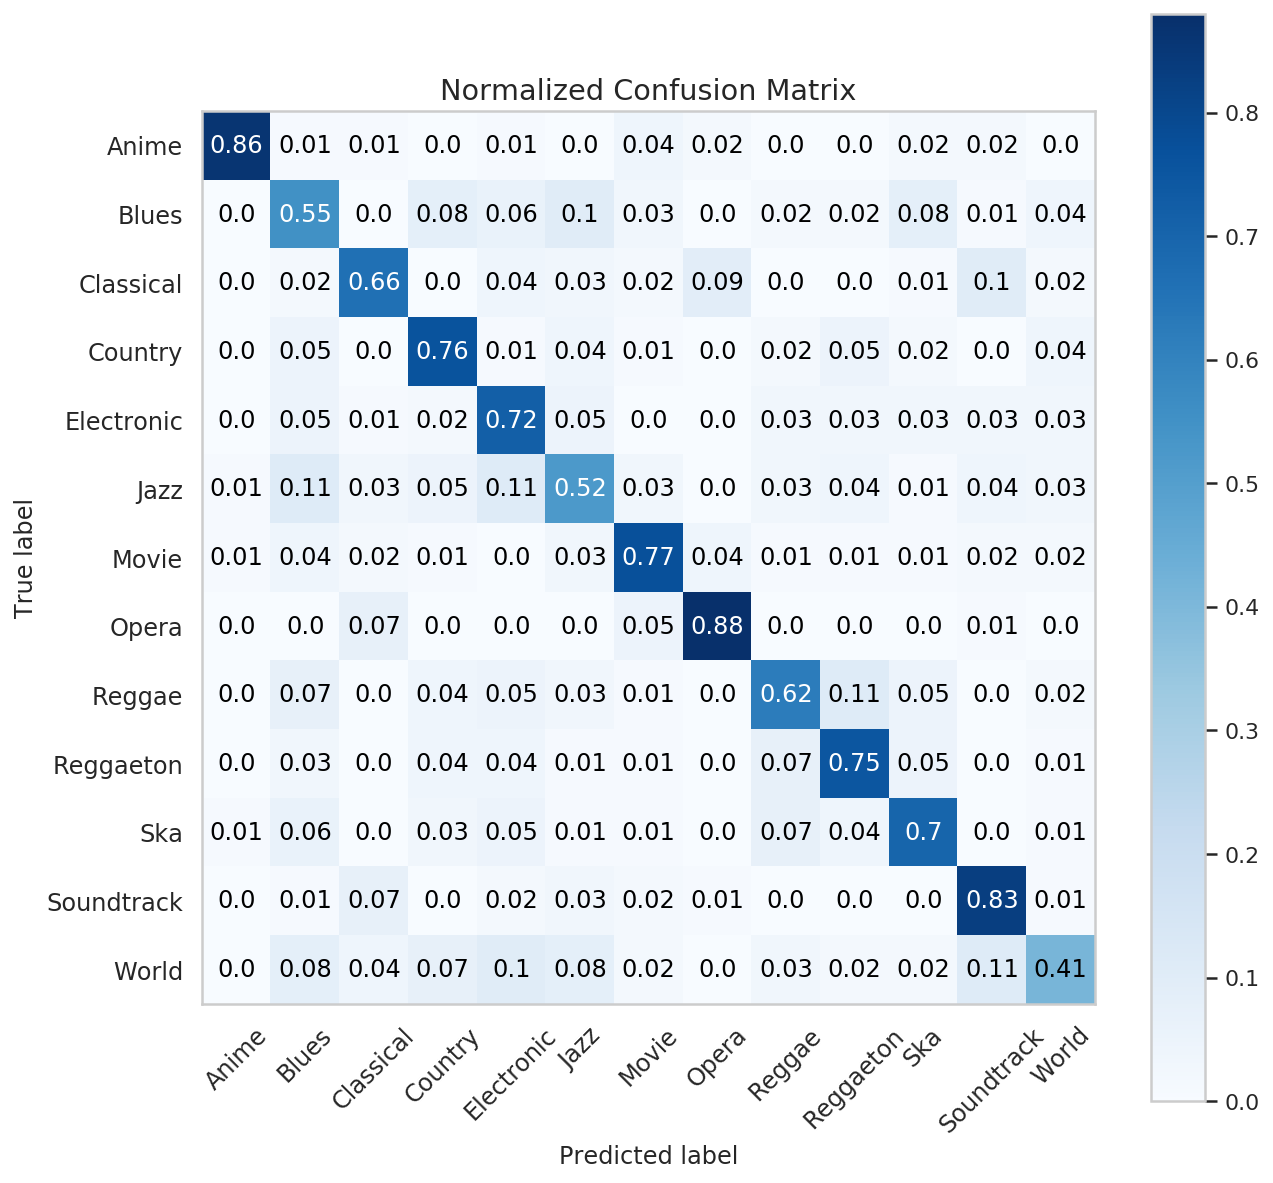

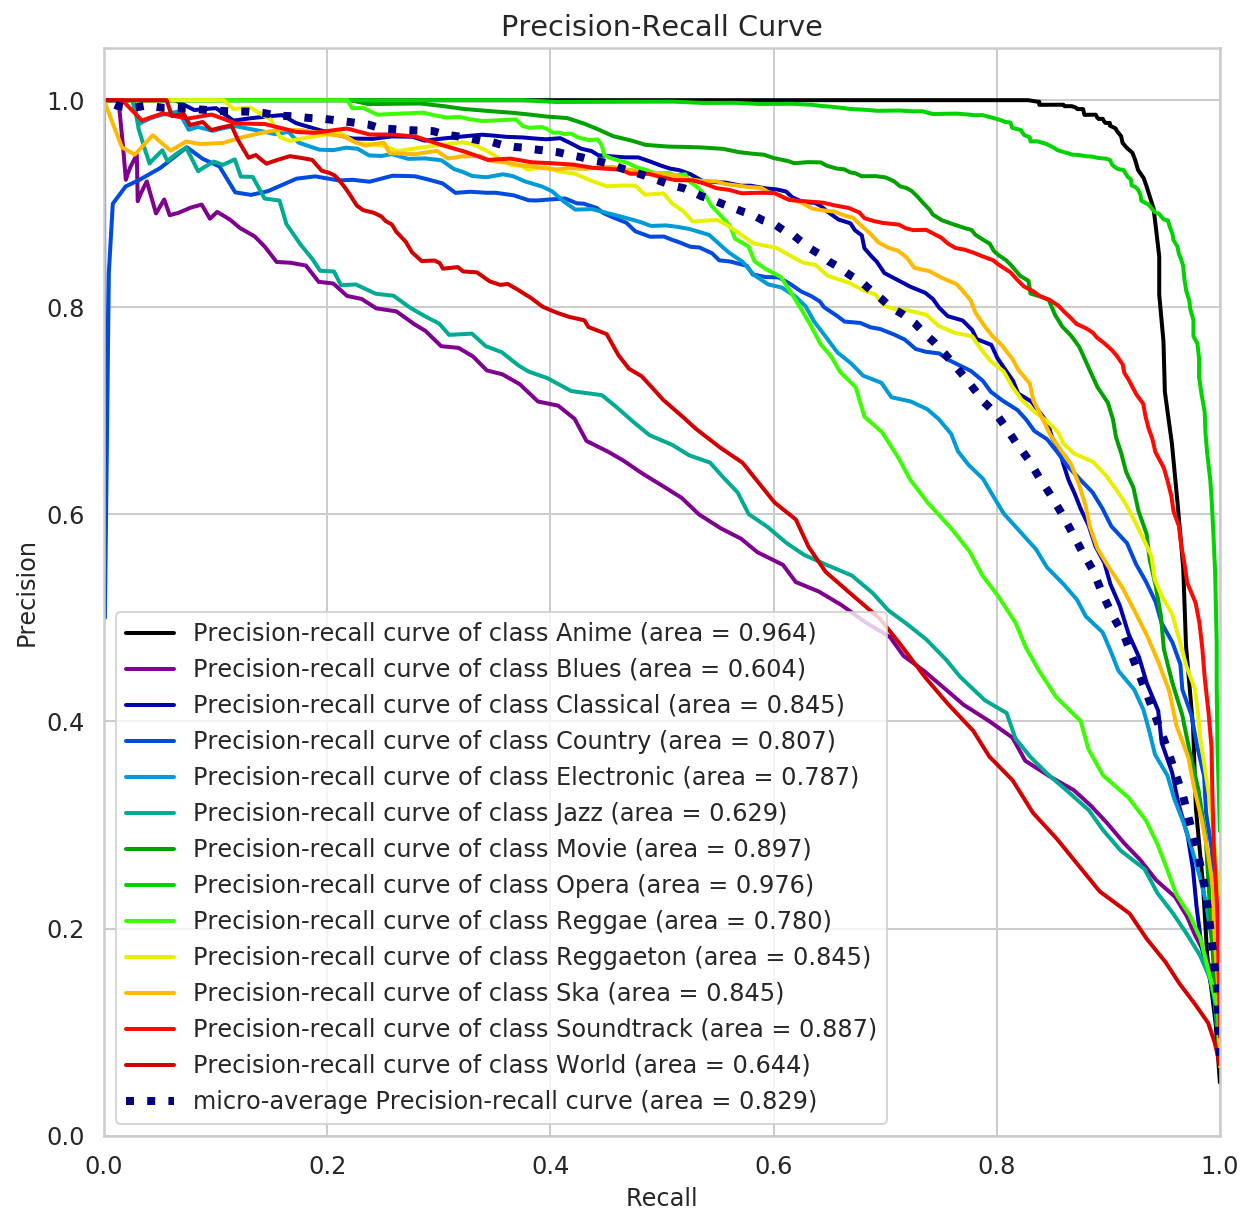

In [0]:
accuracy_plots(X, Y)

In [0]:
# remove 6
remove = ['Anime', 'World', 'Reggaeton', 'Country', 'Movie', 'Jazz']

In [0]:
df_rem = remove_genre(df_rem, remove)

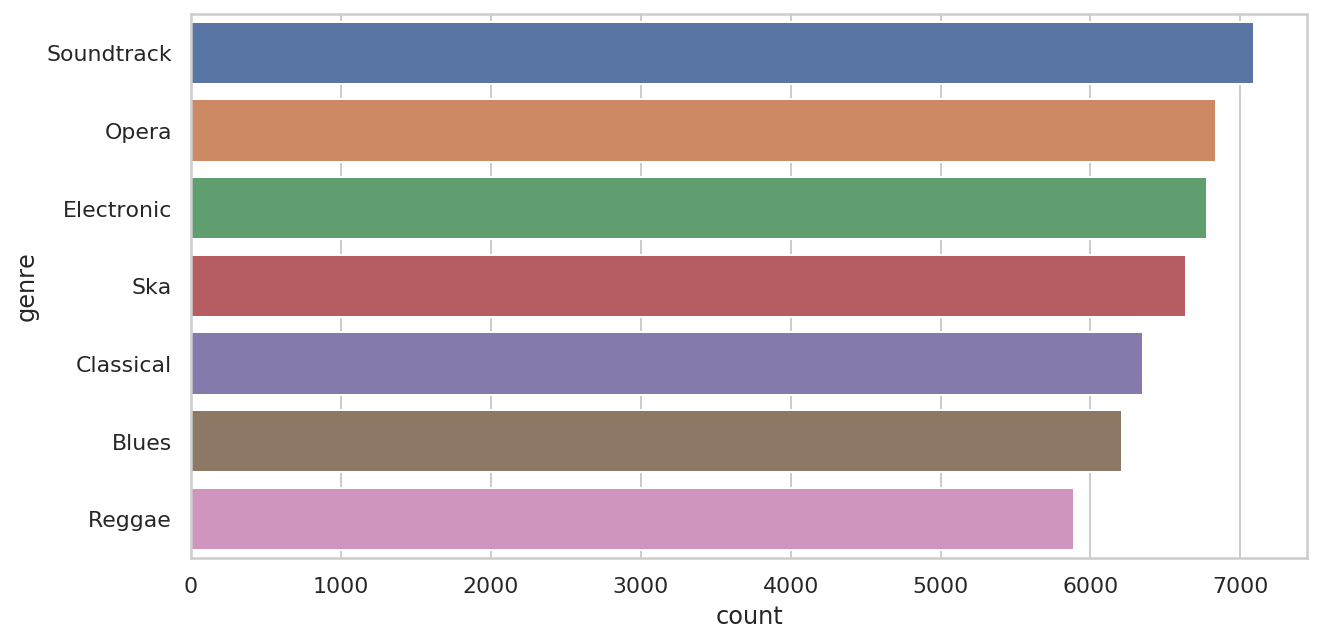

In [0]:
plt.figure(figsize=(10,5))
sns.countplot(y="genre", order=df_rem.genre.value_counts().index, data=df_rem)

In [0]:
df_rem.genre.nunique()

7

In [0]:
X = df_rem.drop(columns=['genre'])
Y = df_rem['genre']

In [0]:
baseline_test(X, Y)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


logistic regression train accuracy: 0.3487115090631142
logistic regression test accuracy: 0.34534337809804566

logistic regression train log loss: 1.6763026647821406
logistic regression test log loss: 1.6942001259696358

random forest classifier train accuracy: 0.9999727014632016
random forest classifier test accuracy: 0.8356807511737089

random forest classifier train log loss: 0.13197218545031128
random forest classifier test log loss: 0.53891626761753

k nearest neighbor train accuracy: 0.5082441581131252
k nearest neighbor test accuracy: 0.27546675401244675

k nearest neighbor train log loss: 1.0445495724372649
k nearest neighbor test log loss: 11.798106308143057

gradient boosting classifier train accuracy: 0.8641351823542258
gradient boosting classifier test accuracy: 0.8341522000218364

gradient boosting classifier train log loss: 0.3893567790722153
gradient boosting classifier test log loss: 0.4575362519180158



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=FutureWarning)


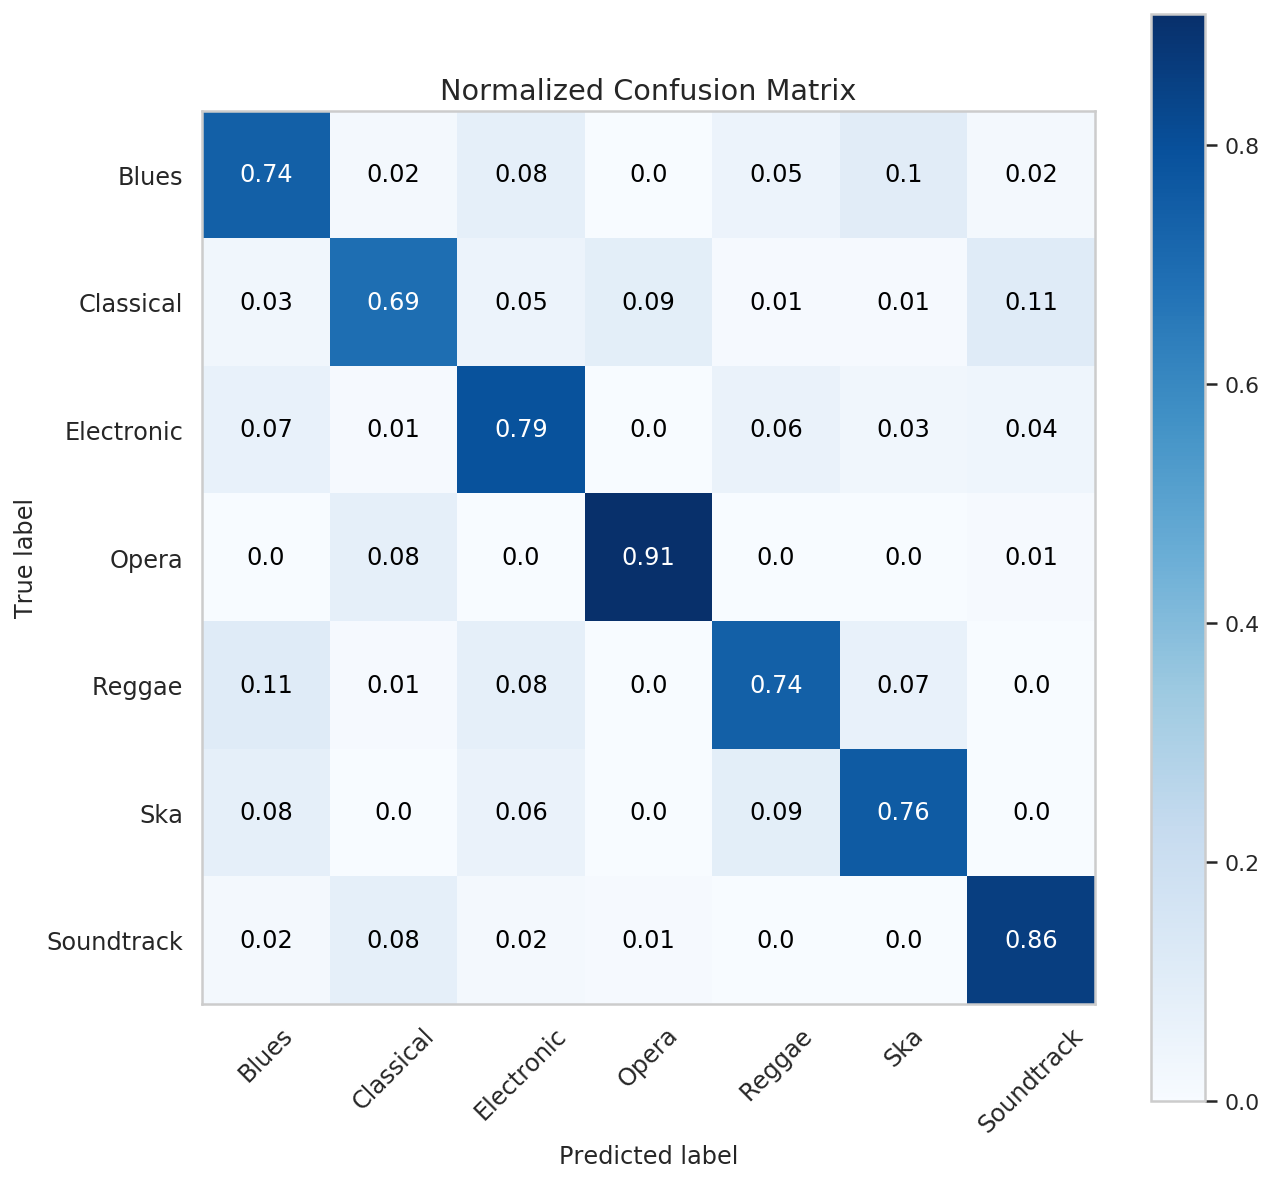

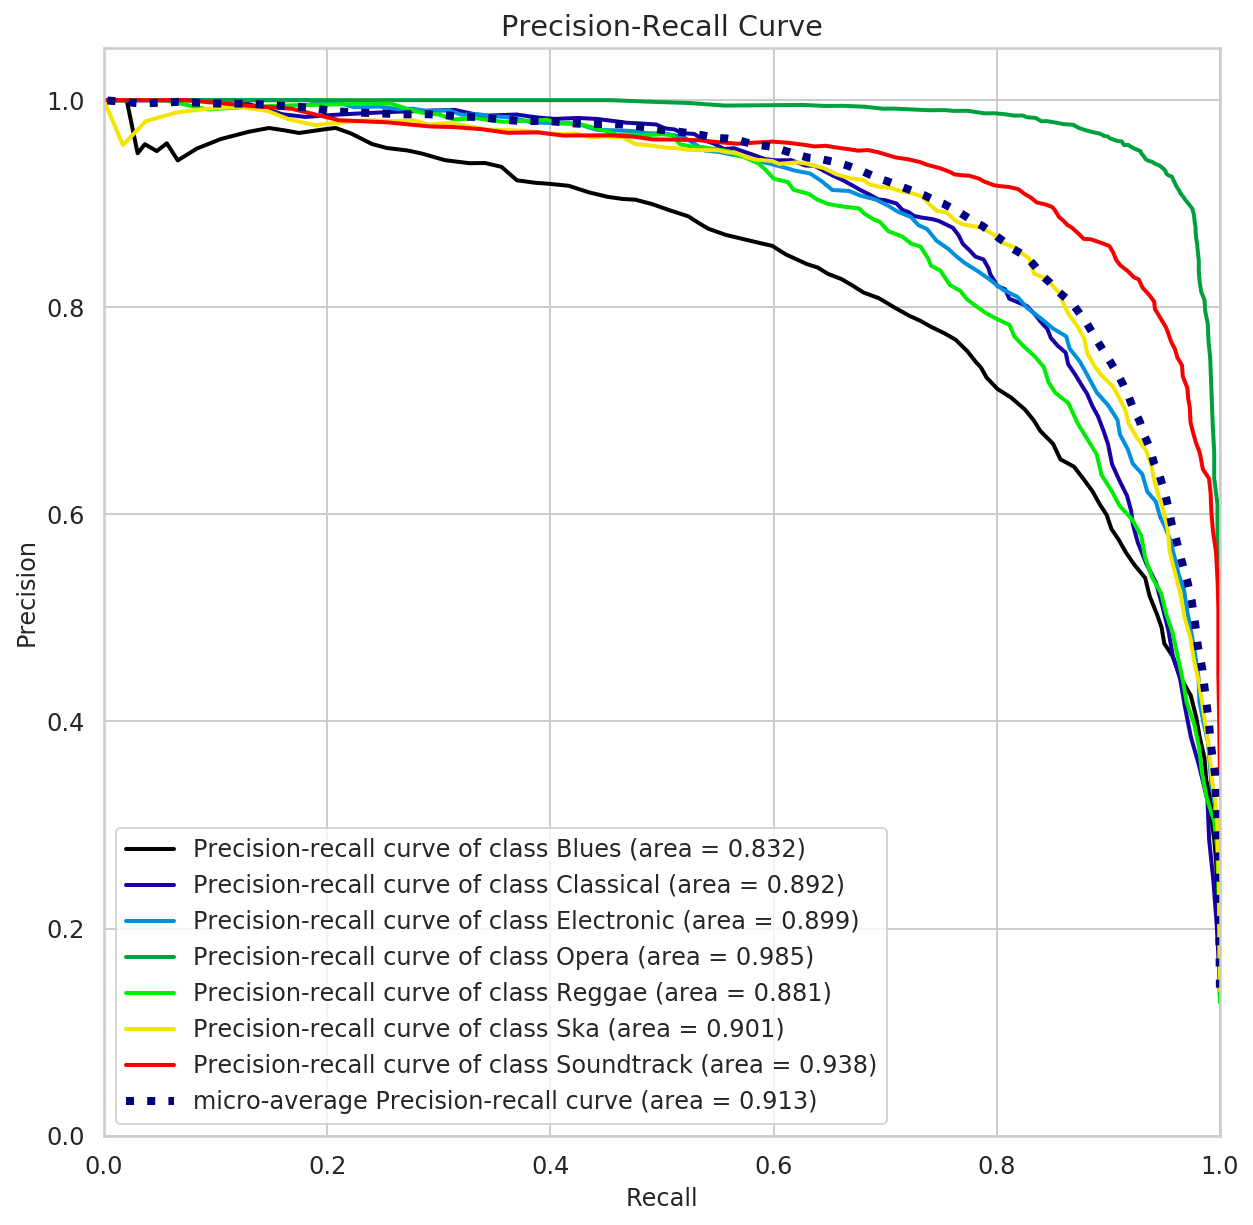

In [0]:
accuracy_plots(X, Y)

In [0]:
# remove 3

remove = ['Reggae', 'Blues', 'Classical']

In [0]:
df_rem = remove_genre(df_rem, remove)

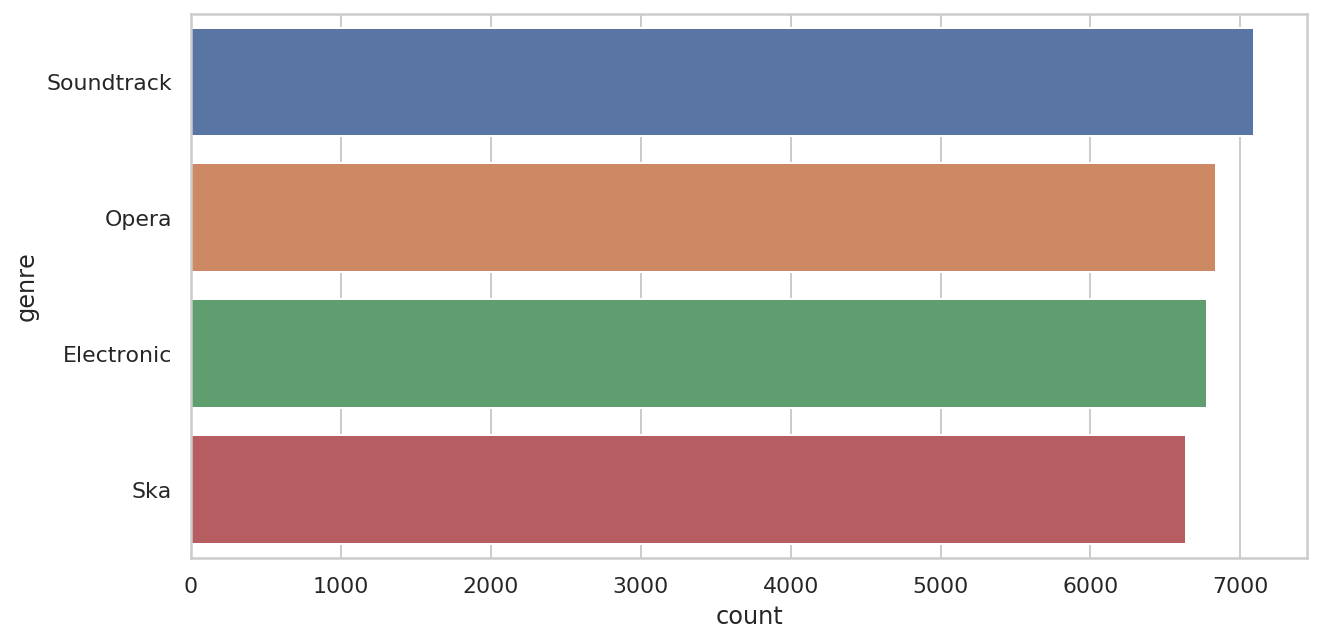

In [0]:
plt.figure(figsize=(10,5))
sns.countplot(y="genre", order=df_rem.genre.value_counts().index, data=df_rem)

In [0]:
X = df_rem.drop(columns=['genre'])
Y = df_rem['genre']

In [0]:
baseline_test(X, Y)

logistic regression train accuracy: 0.5307242136064374
logistic regression test accuracy: 0.5266044980800878

logistic regression train log loss: 1.1096423949032785
logistic regression test log loss: 1.1153990426222422

random forest classifier train accuracy: 0.999954279444038
random forest classifier test accuracy: 0.9502651307368806

random forest classifier train log loss: 0.05323345054698897
random forest classifier test log loss: 0.1772569820578895

k nearest neighbor train accuracy: 0.6133412582297001
k nearest neighbor test accuracy: 0.41872371548729204

k nearest neighbor train log loss: 0.7978856923583927
k nearest neighbor test log loss: 6.179471976676771

gradient boosting classifier train accuracy: 0.9674012435991222
gradient boosting classifier test accuracy: 0.9519107697933809

gradient boosting classifier train log loss: 0.09632515907755464
gradient boosting classifier test log loss: 0.13786069125899428



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=FutureWarning)


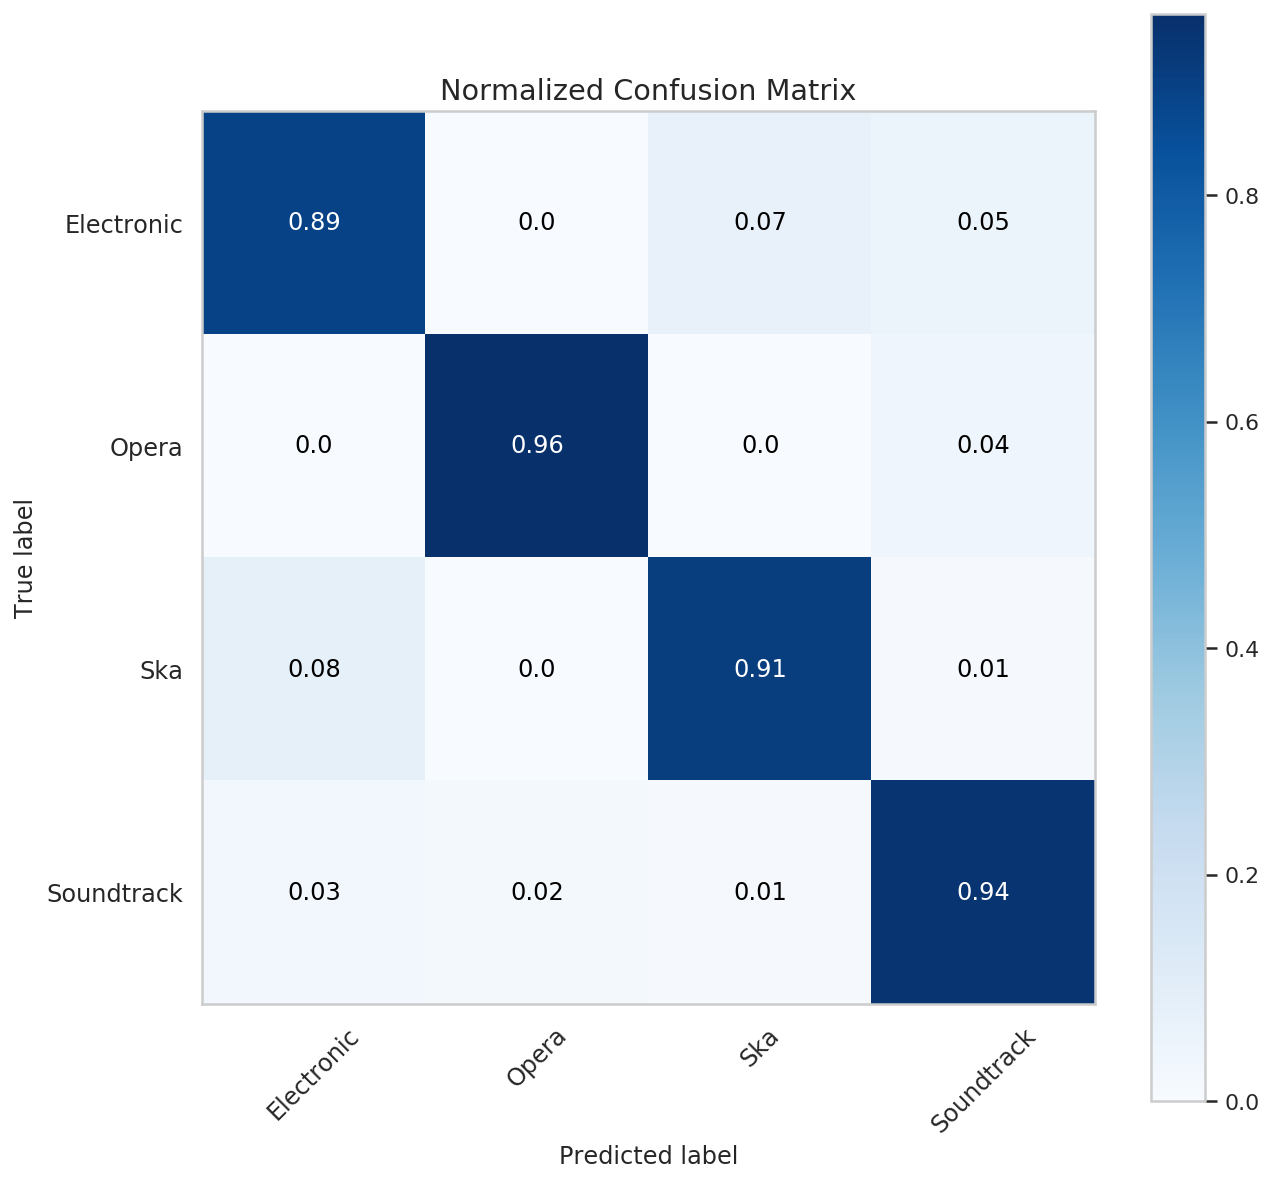

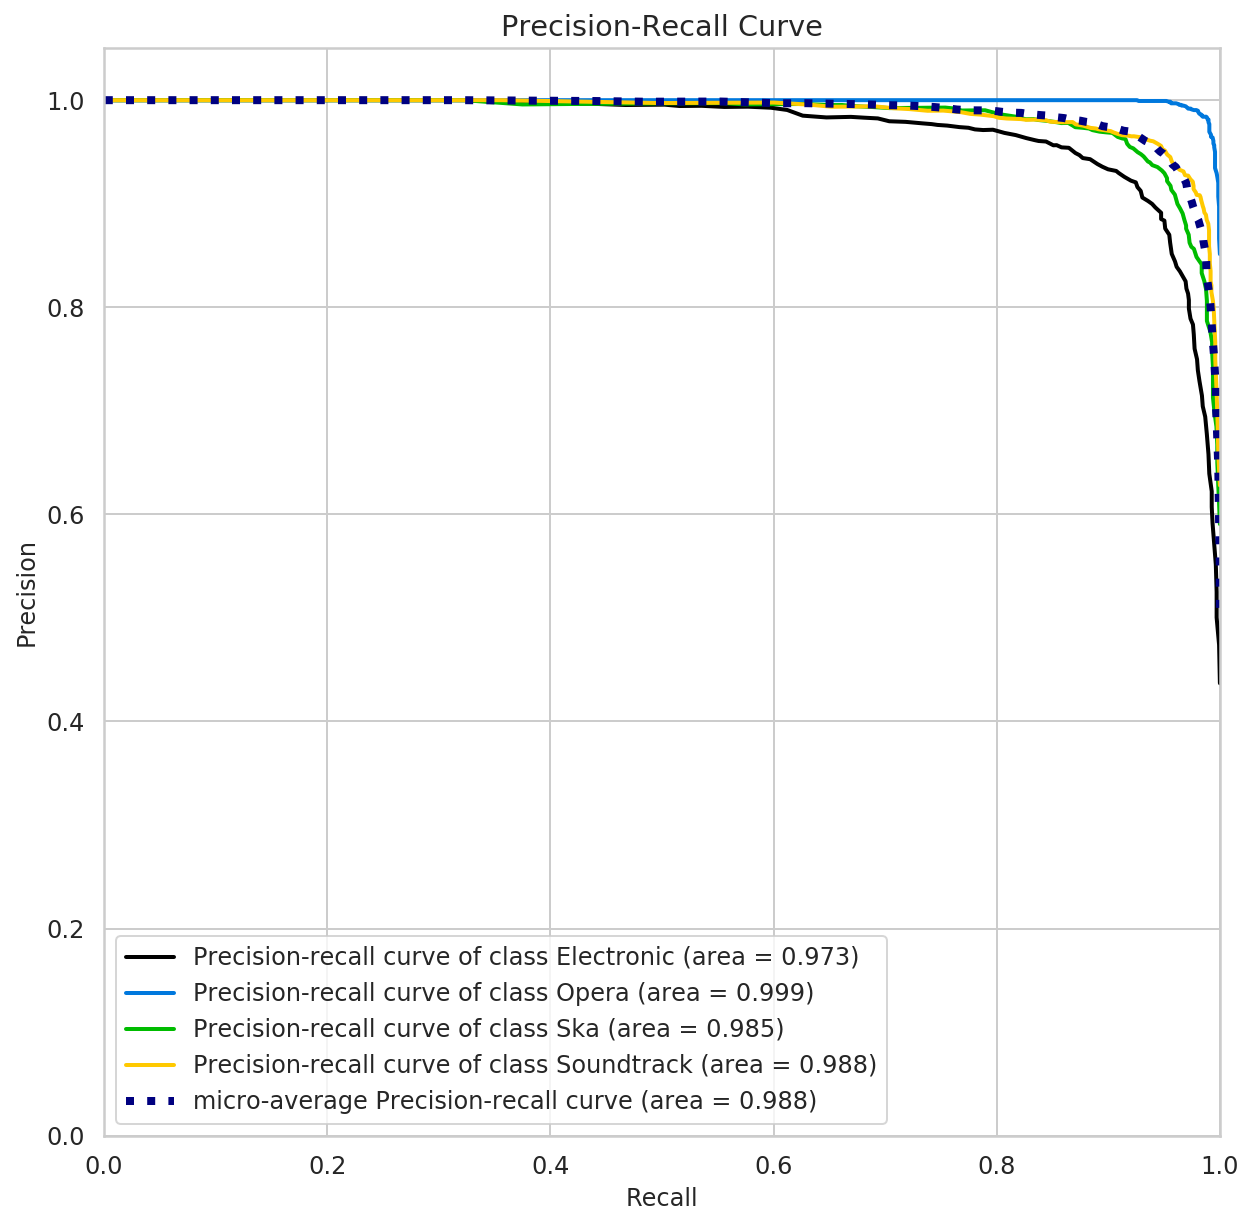

In [0]:
accuracy_plots(X, Y)

In [0]:
# remove 2

remove = ['Ska', 'Soundtrack']

In [0]:
df_rem = remove_genre(df_rem, remove)

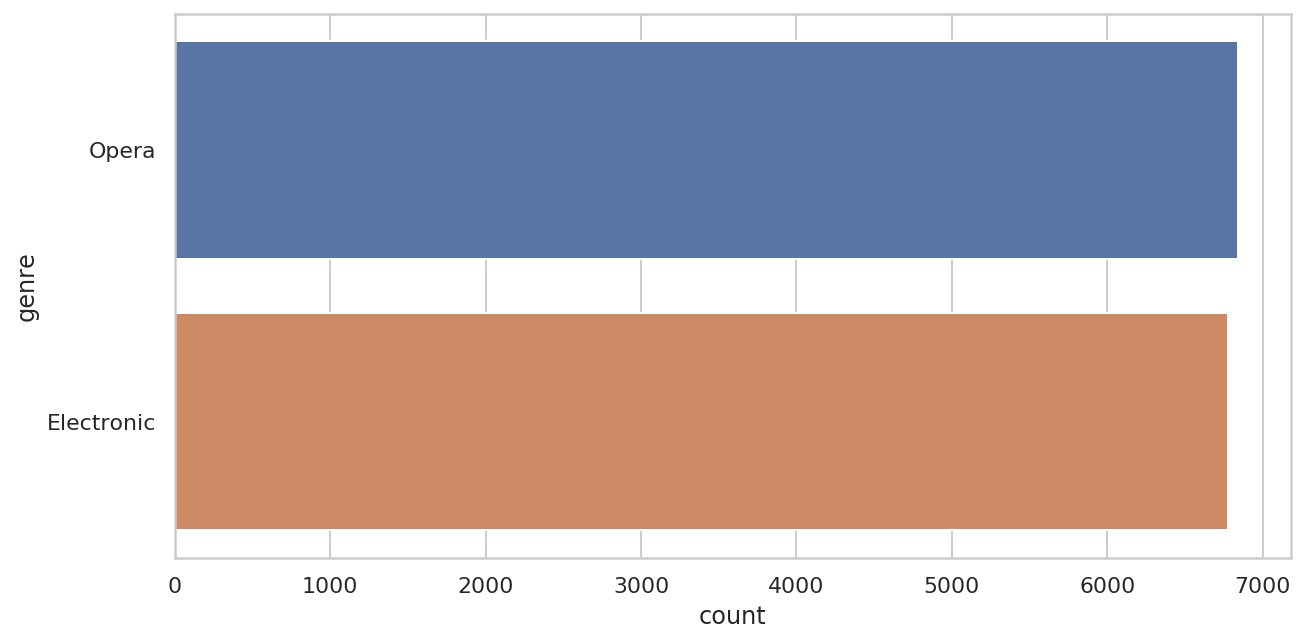

In [0]:
plt.figure(figsize=(10,5))
sns.countplot(y="genre", order=df_rem.genre.value_counts().index, data=df_rem)

In [0]:
df_rem.genre.nunique()

2

In [0]:
X = df_rem.drop(columns=['genre'])
Y = df_rem['genre']

In [0]:
baseline_test(X, Y)

logistic regression train accuracy: 0.8877972637957947
logistic regression test accuracy: 0.9030481087036357

logistic regression train log loss: 0.29541601338356693
logistic regression test log loss: 0.2767277846832568

random forest classifier train accuracy: 1.0
random forest classifier test accuracy: 0.9963275798751378

random forest classifier train log loss: 0.00467047343670242
random forest classifier test log loss: 0.01689614448278843

k nearest neighbor train accuracy: 0.7828482233036452
k nearest neighbor test accuracy: 0.6345941975762027

k nearest neighbor train log loss: 0.4410197635649603
k nearest neighbor test log loss: 1.798678684663767

gradient boosting classifier train accuracy: 1.0
gradient boosting classifier test accuracy: 0.9963275798751378

gradient boosting classifier train log loss: 0.000556343054582452
gradient boosting classifier test log loss: 0.00881902584123609



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=FutureWarning)


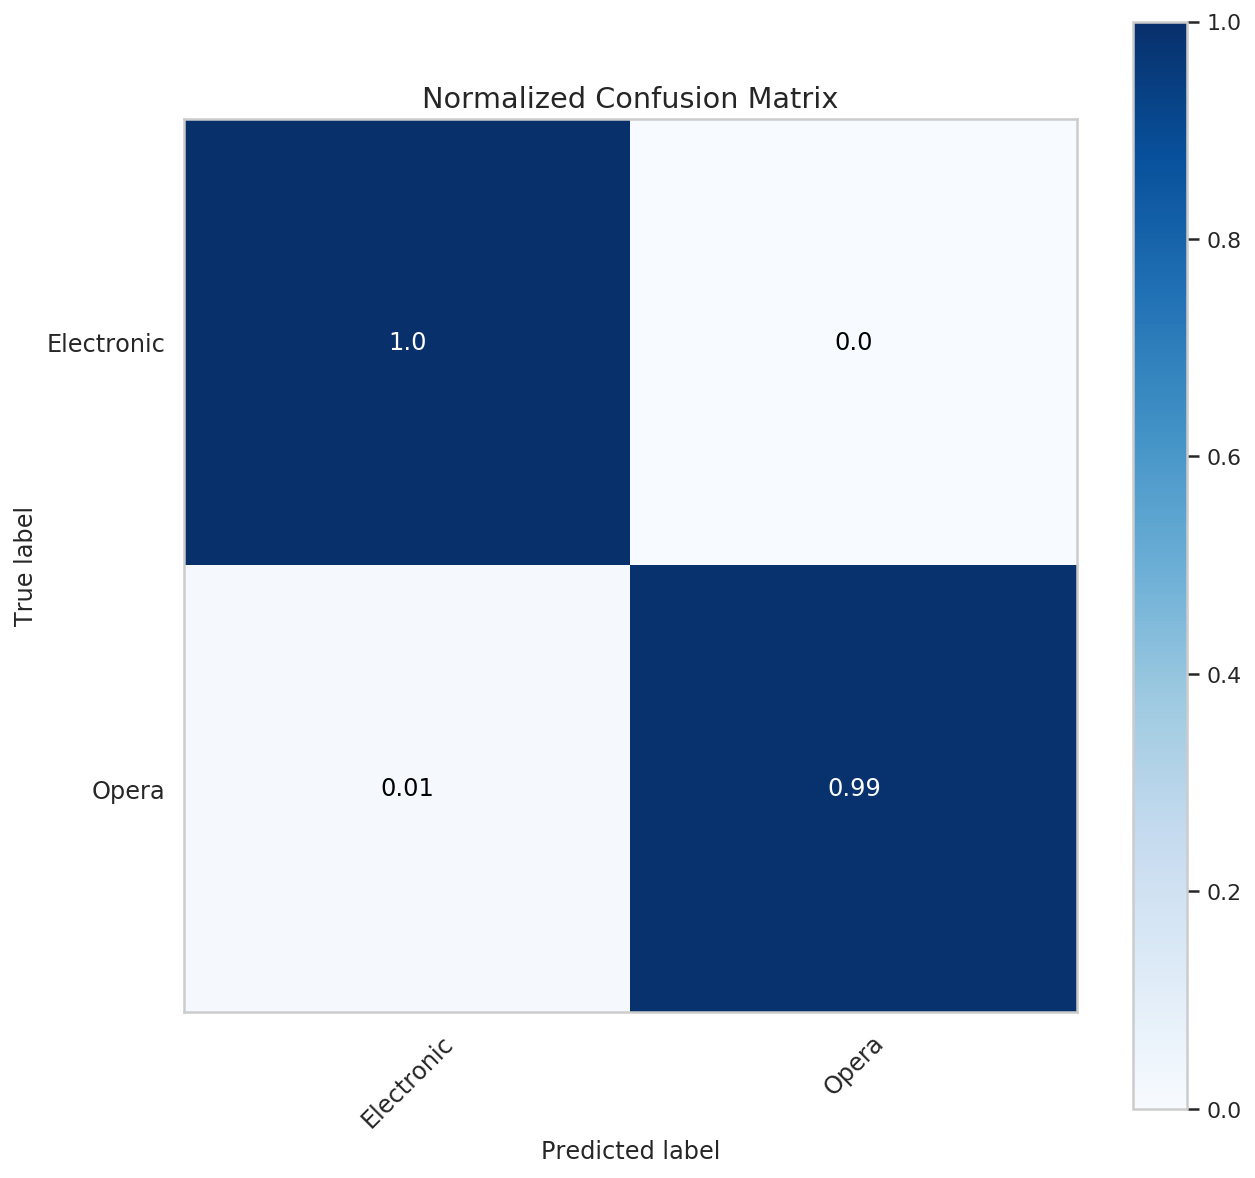

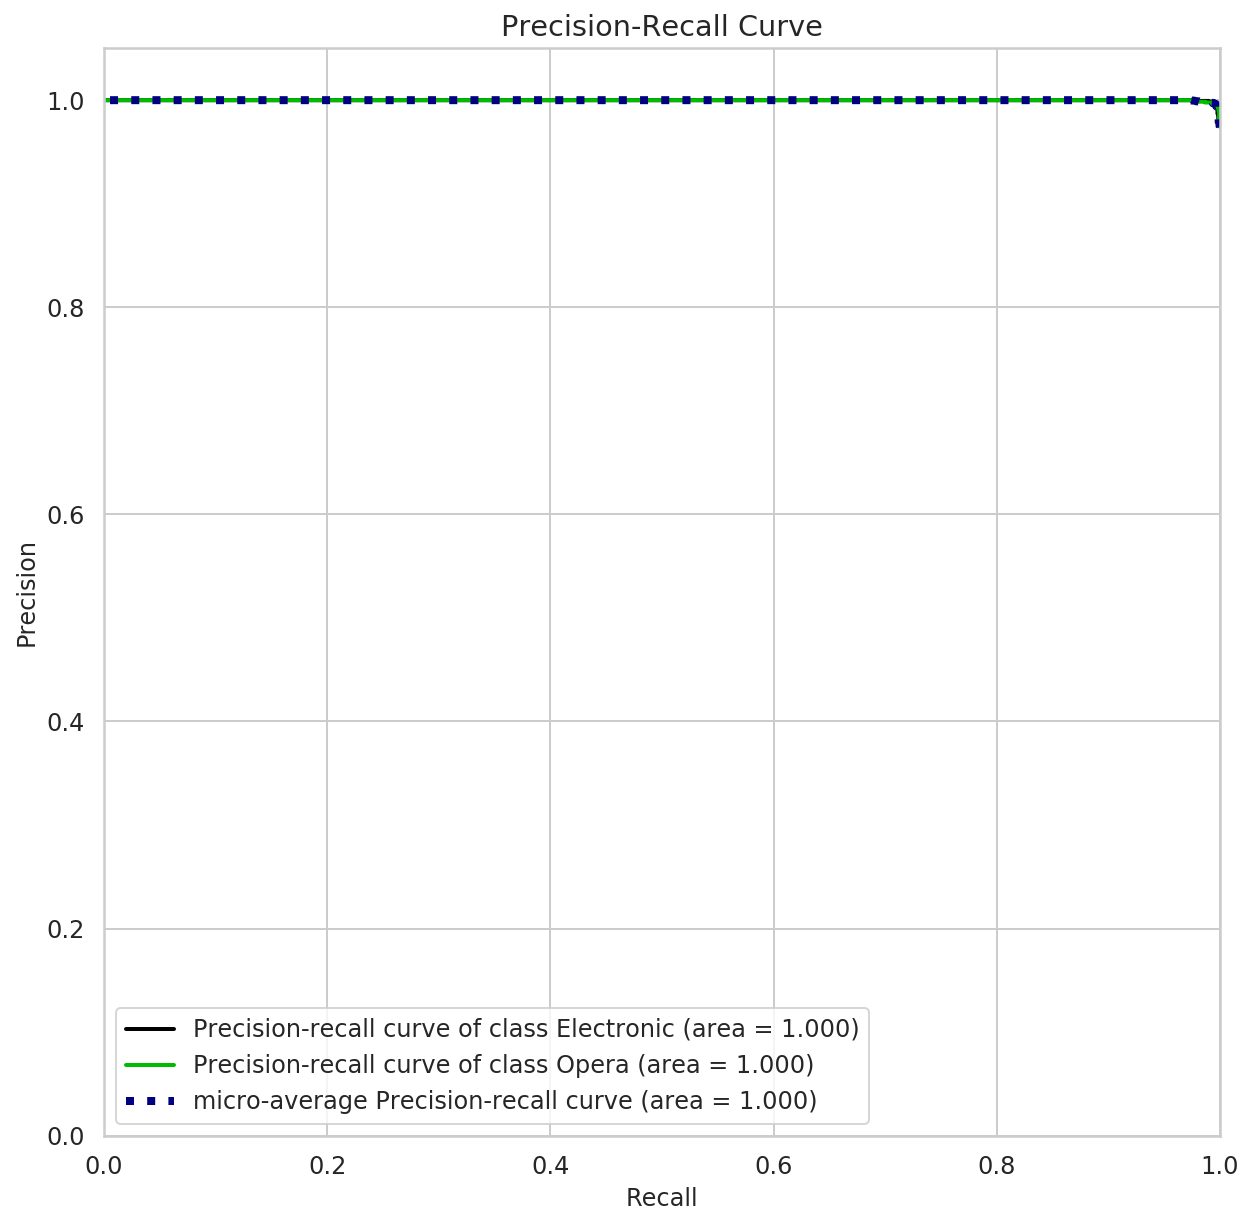

In [0]:
accuracy_plots(X, Y)

## Reduce Classes

In [0]:
df_red = df.copy() # reduce genres

In [0]:
def limit_genres(x):
    if (x in remove):
        x = 'Other'  
    return x

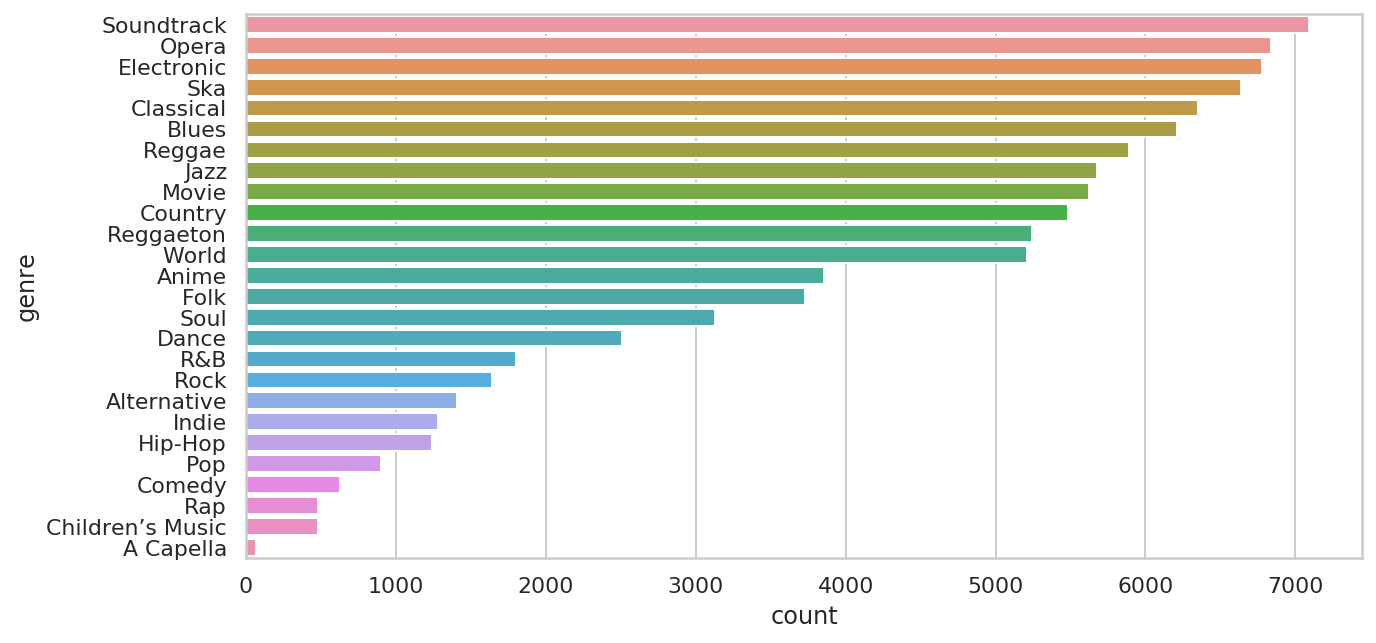

In [0]:
plt.figure(figsize=(10,5))
sns.countplot(y="genre", order=df_red.genre.value_counts().index, data=df_red)

In [0]:
X = df_red.drop(columns=['genre'])
Y = df_red['genre']

In [0]:
baseline_test(X, Y)

random forest classifier train accuracy: 1.0
random forest classifier test accuracy: 0.6394260761072988

random forest classifier train log loss: 0.24175241615639267
random forest classifier test log loss: 1.5083078723433512



In [0]:
remove = ['A Capella', 'Children’s Music', 'Rap', 'Comedy', 'Pop', 'Hip-Hop', 'Indie', 'Alternative', 'Rock', 'R&B', 'Dance', 'Soul', 'Folk']
df_red.genre = df_red.genre.apply(limit_genres)

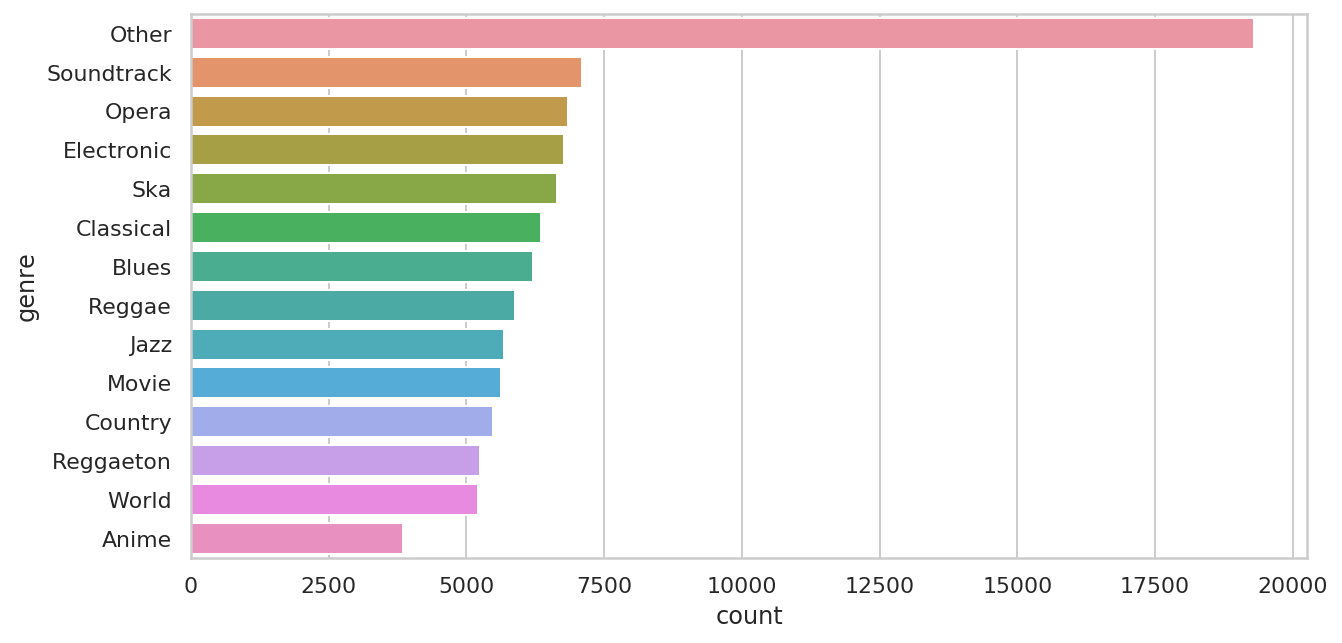

In [0]:
plt.figure(figsize=(10,5))
sns.countplot(y="genre", order=df_red.genre.value_counts().index, data=df_red)

In [0]:
X = df_red.drop(columns=['genre'])
Y = df_red['genre']

In [0]:
baseline_test(X, Y)

random forest classifier train accuracy: 1.0
random forest classifier test accuracy: 0.7080993969640258

random forest classifier train log loss: 0.20568851436730645
random forest classifier test log loss: 1.0246915517545645



In [0]:
remove = ['Anime', 'World', 'Reggaeton', 'Country', 'Movie', 'Jazz']
df_red.genre = df_red.genre.apply(limit_genres)

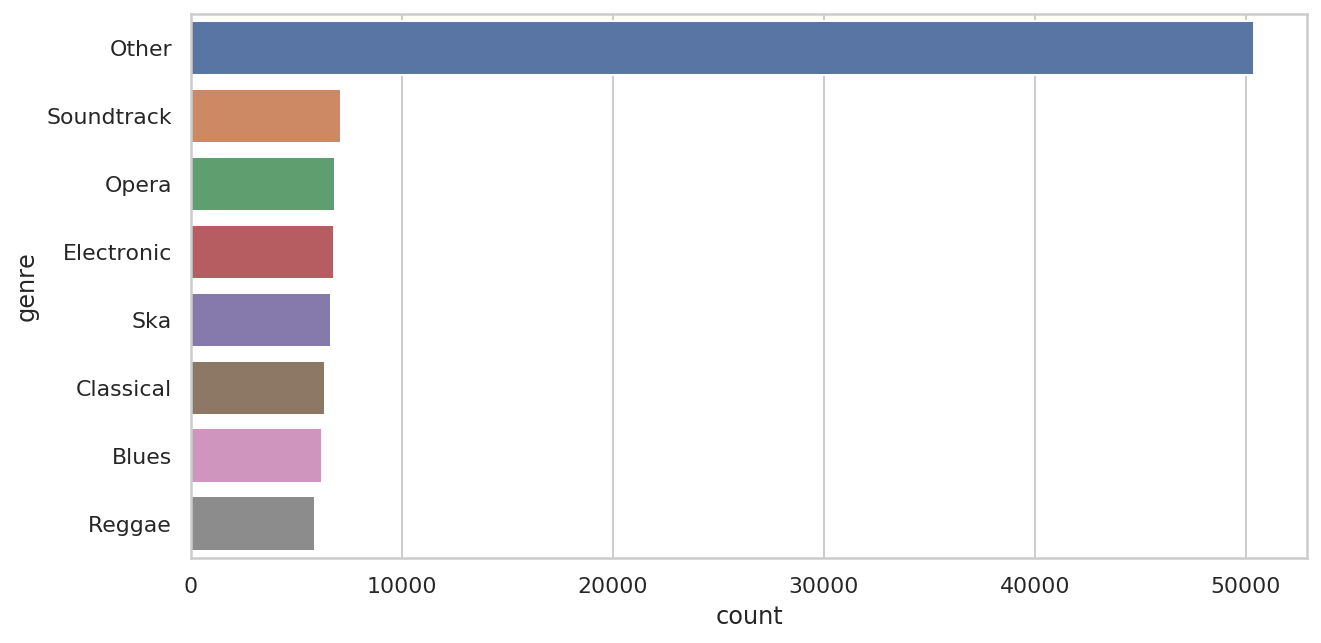

In [0]:
plt.figure(figsize=(10,5))
sns.countplot(y="genre", order=df_red.genre.value_counts().index, data=df_red)

In [0]:
X = df_red.drop(columns=['genre'])
Y = df_red['genre']

In [0]:
baseline_test(X, Y)

random forest classifier train accuracy: 0.9999870031972135
random forest classifier test accuracy: 0.8029735911831982

random forest classifier train log loss: 0.139588098644002
random forest classifier test log loss: 0.6624647266661777



In [0]:
remove = ['Reggae', 'Blues', 'Classical']
df_red.genre = df_red.genre.apply(limit_genres)

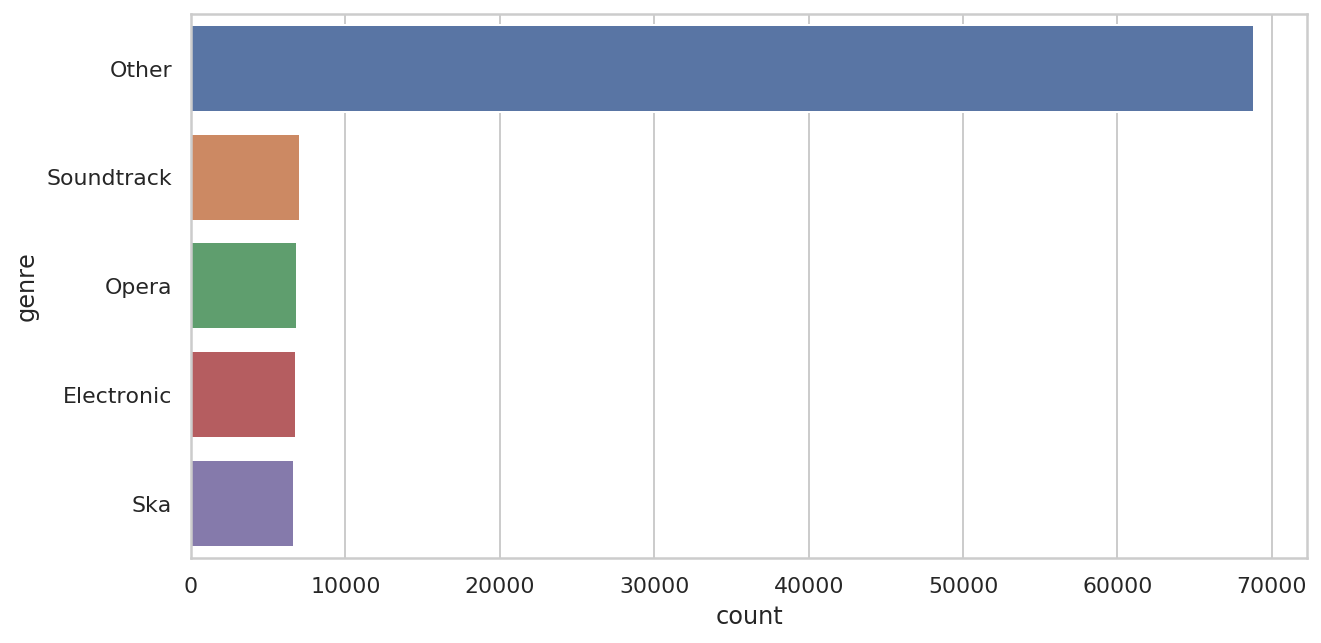

In [0]:
plt.figure(figsize=(10,5))
sns.countplot(y="genre", order=df_red.genre.value_counts().index, data=df_red)

In [0]:
X = df_red.drop(columns=['genre'])
Y = df_red['genre']

In [0]:
baseline_test(X, Y)

random forest classifier train accuracy: 0.9999870031972135
random forest classifier test accuracy: 0.8836556456643793

random forest classifier train log loss: 0.08544078620431228
random forest classifier test log loss: 0.36217512980623945



In [0]:
remove = ['Ska', 'Soundtrack']
df_red.genre = df_red.genre.apply(limit_genres)

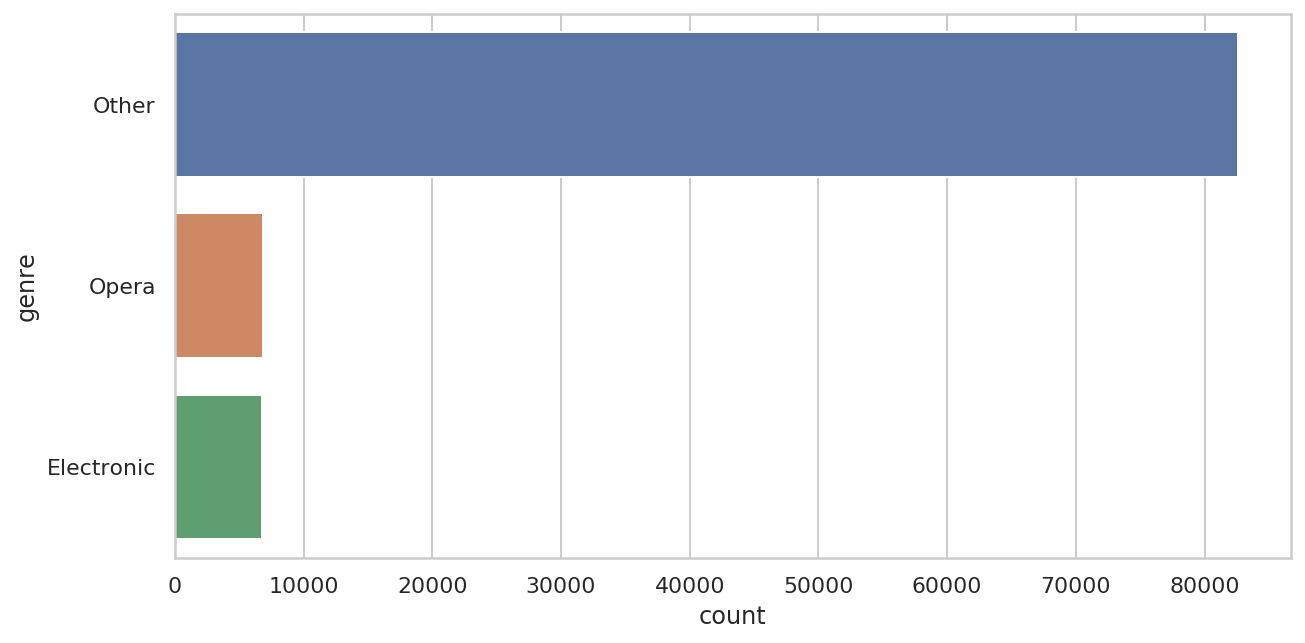

In [0]:
plt.figure(figsize=(10,5))
sns.countplot(y="genre", order=df_red.genre.value_counts().index, data=df_red)

In [0]:
X = df_red.drop(columns=['genre'])
Y = df_red['genre']

In [0]:
baseline_test(X, Y)

random forest classifier train accuracy: 1.0
random forest classifier test accuracy: 0.9400603035974215

random forest classifier train log loss: 0.042992780413093915
random forest classifier test log loss: 0.1759001174920799



In [0]:
remove = ['Electronic']
df_red.genre = df_red.genre.apply(limit_genres)

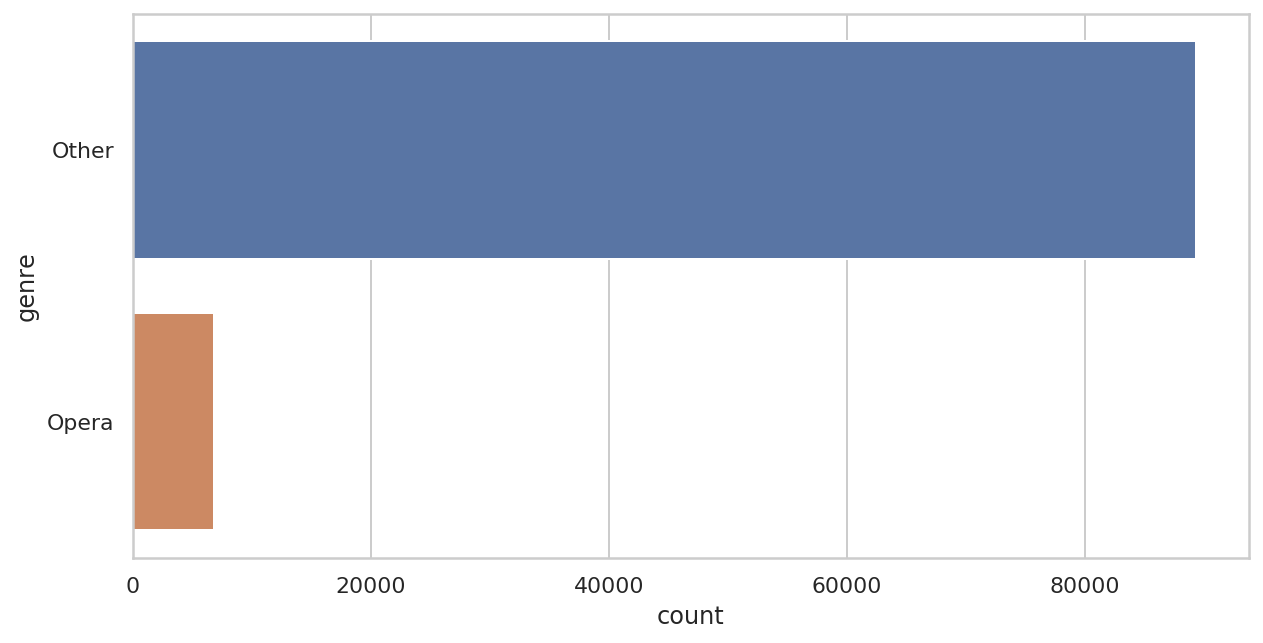

In [0]:
plt.figure(figsize=(10,5))
sns.countplot(y="genre", order=df_red.genre.value_counts().index, data=df_red)

In [0]:
X = df_red.drop(columns=['genre'])
Y = df_red['genre']

In [0]:
baseline_test(X, Y)

random forest classifier train accuracy: 1.0
random forest classifier test accuracy: 0.9882511956747765

random forest classifier train log loss: 0.010649226894743591
random forest classifier test log loss: 0.038088335819935426



In [0]:
print("--- %s seconds ---" % (time.time() - start_time))

In [0]:
print((time.time() - start_time)/60, 'minutes')